# BatFlightAnalysis

## Paquetes

In [3]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import wilcoxon

from BatFlightAnalysis import read_data, split_data

In [4]:
import warnings

warnings.filterwarnings("ignore")

## Funciones

In [5]:
def curvatura(df):
    # Convertir a arrays de numpy
    x = np.array(df['x'])
    y = np.array(df['y'])
    z = np.array(df['z'])

    # Calcular las derivadas usando diferencias finitas
    dx = np.gradient(x)
    dy = np.gradient(y)
    dz = np.gradient(z)

    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    ddz = np.gradient(dz)

    # Calcular la curvatura
    curvatura = np.zeros(len(x))

    for i in range(len(x)):
        # Vectores de la primera y segunda derivada
        r_prime = np.array([dx[i], dy[i], dz[i]])
        r_double_prime = np.array([ddx[i], ddy[i], ddz[i]])
        
        # Producto cruzado de r' y r''
        cross_product = np.cross(r_prime, r_double_prime)
        
        # Magnitud de r'
        norm_r_prime = np.linalg.norm(r_prime)
        
        # Curvatura
        curvatura[i] = np.linalg.norm(cross_product) / (norm_r_prime**3)

    # Desviación Estándar de la curvatura
    std_curvatura = np.std(curvatura)

    # Media de la curvatura
    mean_curvatura = np.mean(curvatura)

    # Integral de la curvatura
    integral_curvatura = np.trapz(curvatura)

    return mean_curvatura, std_curvatura, integral_curvatura

def velocidad(df):
    # Convertir a arrays de numpy
    x = np.array(df['x'])
    y = np.array(df['y'])
    z = np.array(df['z'])

    # Calcular las derivadas usando diferencias finitas
    dx = np.gradient(x)
    dy = np.gradient(y)
    dz = np.gradient(z)

    # Calcular la magnitud de la velocidad en cada punto
    velocidad = np.zeros(len(x))
    for i in range(len(x)):
        r_prime = np.array([dx[i], dy[i], dz[i]])
        velocidad[i] = np.linalg.norm(r_prime)

    # Desviación Estándar de la velocidad
    std_velocidad = np.std(velocidad)

    # Media de la velocidad
    mean_velocidad = np.mean(velocidad)

    # Integral de la velocidad
    integral_velocidad = np.trapz(velocidad)

    return mean_velocidad, std_velocidad, integral_velocidad

def torsion(df):
    # Convertir a arrays de numpy
    x = np.array(df['x'])
    y = np.array(df['y'])
    z = np.array(df['z'])

    # Calcular las derivadas usando diferencias finitas
    dx = np.gradient(x)
    dy = np.gradient(y)
    dz = np.gradient(z)

    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    ddz = np.gradient(dz)

    dddx = np.gradient(ddx)
    dddy = np.gradient(ddy)
    dddz = np.gradient(ddz)

    # Calcular la torsión en cada punto
    torsion = np.zeros(len(x))
    for i in range(len(x)):
        r_prime = np.array([dx[i], dy[i], dz[i]])
        r_double_prime = np.array([ddx[i], ddy[i], ddz[i]])
        r_triple_prime = np.array([dddx[i], dddy[i], dddz[i]])

        # Producto cruzado de r' y r''
        cross_product = np.cross(r_prime, r_double_prime)
        
        # Torsión
        norm_cross_product = np.linalg.norm(cross_product)
        torsion[i] = np.dot(cross_product, r_triple_prime) / (norm_cross_product**2) if norm_cross_product != 0 else 0

    # Desviación Estándar de la torsión
    std_torsion = np.std(torsion)

    # Media de la torsión
    mean_torsion = np.mean(torsion)

    # Integral de la torsión
    integral_torsion = np.trapz(torsion)

    return mean_torsion, std_torsion, integral_torsion

In [6]:
def longitud(df):
    # Convertir a arrays de numpy
    x = np.array(df['x'])
    y = np.array(df['y'])
    z = np.array(df['z'])

    # Longitud de la trayectoria
    longitud = np.zeros(len(x))

    for i in range(1, len(x)):
        longitud[i] = longitud[i-1] + np.sqrt((x[i] - x[i-1])**2 + (y[i] - y[i-1])**2 + (z[i] - z[i-1])**2)

    # Longitud total
    longitud_total = longitud[-1]

    return longitud_total

In [7]:
def var_espacial(df):
    # Convertir a arrays de numpy
    x = np.array(df['x'])
    y = np.array(df['y'])
    z = np.array(df['z'])

    longitud_x = np.max(x) - np.min(x)
    longitud_y = np.max(y) - np.min(y)
    longitud_z = np.max(z) - np.min(z)

    volumen = longitud_x * longitud_y * longitud_z

    return longitud_x, longitud_y, longitud_z, volumen


In [8]:
def hist_plots(whiskers_data, no_whiskers_data, metric):
    print(f"Normality test for {metric}:")
    # Perform normality check for "whiskers" and "no whiskers" groups and plot histograms
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram for 'whiskers'
    axes[0].hist(whiskers_data[metric], bins=15, edgecolor='black', alpha=0.7)
    axes[0].set_title(f'Histogram of {metric} (Whiskers)')


    # Histogram for 'no whiskers'
    axes[1].hist(no_whiskers_data[metric], bins=15, edgecolor='black', alpha=0.7)
    axes[1].set_title(f'Histogram of {metric} (No Whiskers)')

    plt.tight_layout()
    plt.show()

## Código

### Lectura de datos

In [9]:
data_bef, data_fee, data_aft = read_data('data/output_points_1_no_whiskers.xlsx')

In [10]:
# Split data into flower and bat data; before, during, and after feeding
flower_bef, flower_fee, flower_aft, bat_bef, bat_fee, bat_aft = split_data(data_bef, data_fee, data_aft)

# Show the data
print(flower_fee.head())

      x    y      z
9   281   94  349.0
10  283   98  345.0
11  283  100  341.0
12  283  103  338.0
13  288  103  336.0


### Curvatura

In [11]:
mean_curvatura, std_curvatura, int_curvatura = curvatura(flower_fee)
print('Desviación Estándar de la Curvatura:', std_curvatura)
print('Media de la Curvatura:', mean_curvatura)
print('Integral de la Curvatura:', int_curvatura)

Desviación Estándar de la Curvatura: 1.8368621915524173
Media de la Curvatura: 0.5475373323457154
Integral de la Curvatura: 43.19156036642262


### Longitud

In [12]:
# Longitud total
longitud_total = longitud(flower_fee)
print('Longitud Total:', longitud_total)

Longitud Total: 375.82886152263075


### Variación en cada eje

In [13]:
# Variación en cada eje
longitud_x, longitud_y, longitud_z, volumen = var_espacial(flower_fee)

print('Longitud de la trayectoria en el eje x:', longitud_x)
print('Longitud de la trayectoria en el eje y:', longitud_y)
print('Longitud de la trayectoria en el eje z:', longitud_z)
print('Volumen del Espacio:', volumen)

Longitud de la trayectoria en el eje x: 14
Longitud de la trayectoria en el eje y: 15
Longitud de la trayectoria en el eje z: 17.0
Volumen del Espacio: 3570.0


## Iteración sobre archivos

In [14]:
individuo, whiskers, n_vuelo = [], [], []
mean_velocidad, std_velocidad, int_velocidad = [], [], []
mean_curvatura, std_curvatura, int_curvatura = [], [], []
mean_torsion, std_torsion, int_torsion = [], [], []
longitud_total = []
longitud_x, longitud_y, longitud_z, volumen = [], [], [], []

for n in range(6,10):
    # for tipo in ["Whiskers"]:
    for tipo in ["Whiskers", "No whiskers"]:
        # Recorro lo archivos de la capeta Individuo n
        for file in os.listdir(f'data/Individuo {n}/{tipo}'):
            # print("Procesando:", f"Individuo {n}/{tipo}/{file}")

            try:
                data_bef, data_fee, data_aft = read_data(f'data/Individuo {n}/{tipo}/{file}')

                # Split data into flower and bat data; before, during, and after feeding
                flower_bef, flower_fee, flower_aft, bat_bef, bat_fee, bat_aft = split_data(data_bef, data_fee, data_aft)

                # Velocidad
                mean_vel, std_vel, int_vel = velocidad(flower_fee)
                mean_velocidad.append(mean_vel)
                std_velocidad.append(std_vel)
                int_velocidad.append(int_vel)

                # Curvatura
                mean_curv, std_curv, int_curv = curvatura(flower_fee)
                mean_curvatura.append(mean_curv)
                std_curvatura.append(std_curv)
                int_curvatura.append(int_curv)

                # Torsión
                mean_tor, std_tor, int_tor = torsion(flower_fee)
                mean_torsion.append(mean_tor)
                std_torsion.append(std_tor)
                int_torsion.append(int_tor)

                # Longitud total
                long = longitud(flower_fee)
                longitud_total.append(long)

                # Variación en cada eje
                long_x, long_y, long_z, vol = var_espacial(flower_fee)
                longitud_x.append(long_x)
                longitud_y.append(long_y)
                longitud_z.append(long_z)
                volumen.append(vol)

                individuo.append(n)
                whiskers.append(tipo)
                n_vuelo.append(file.split('_')[-1].split('.')[0])
            except:
                print("Error en el archivo:", f"Individuo {n}/{tipo}/{file}")

# Creo el conjunto de datos
df = pd.DataFrame({
    'Individuo': individuo,
    'Tipo': whiskers,
    'No. Vuelo': n_vuelo,
    'Velocidad Media': mean_velocidad,
    'Desviación Estándar de la Velocidad': std_velocidad,
    'Integral de la Velocidad': int_velocidad,
    'Curvatura Media': mean_curvatura,
    'Desviación Estándar de la Curvatura': std_curvatura,
    'Integral de la Curvatura': int_curvatura,
    'Torsión Media': mean_torsion,
    'Desviación Estándar de la Torsión': std_torsion,
    'Integral de la Torsión': int_torsion,
    'Longitud Total': longitud_total,
    'Longitud en X': longitud_x,
    'Longitud en Y': longitud_y,
    'Longitud en Z': longitud_z,
    'Volumen': volumen
})

# Muestro los datos
display(df.head())

Error en el archivo: Individuo 6/No whiskers/output_points_7.xlsx


,Individuo,Tipo,No. Vuelo,Velocidad Media,Desviación Estándar de la Velocidad,Integral de la Velocidad,Curvatura Media,Desviación Estándar de la Curvatura,Integral de la Curvatura,Torsión Media,Desviación Estándar de la Torsión,Integral de la Torsión,Longitud Total,Longitud en X,Longitud en Y,Longitud en Z,Volumen
0,6,Whiskers,1,3.685155,2.469856,62.346961,0.319137,0.309382,5.333128,-0.025381,0.120565,-0.422220,75.694841,18.0,14.0,19.0,4788.0
1,6,Whiskers,10,8.442801,5.213999,244.123139,0.061655,0.072966,1.756422,-0.022569,0.129216,-0.701873,260.010676,54.0,40.0,125.0,270000.0
2,6,Whiskers,11,3.832310,2.993198,62.419556,1.097282,3.454947,19.665025,-0.113609,0.256775,-2.043465,80.997540,7.0,21.0,18.0,2646.0
3,6,Whiskers,12,7.883429,3.940560,124.664154,0.128108,0.231968,2.129493,0.038921,0.102573,0.657215,131.251894,21.0,40.0,93.0,78120.0
4,6,Whiskers,13,3.654315,2.337232,47.331496,0.255117,0.302641,3.785561,0.012112,0.194771,0.167200,58.087628,10.0,11.0,16.0,1760.0


In [15]:
# Guardo los datos
df.to_excel('data/mediciones.xlsx', index=False)

## Análisis comparativo

In [16]:
# Leo el archivo de datos
data = pd.read_excel('data/mediciones.xlsx')

display(data.head())

,Individuo,Tipo,No. Vuelo,Velocidad Media,Desviación Estándar de la Velocidad,Integral de la Velocidad,Curvatura Media,Desviación Estándar de la Curvatura,Integral de la Curvatura,Torsión Media,Desviación Estándar de la Torsión,Integral de la Torsión,Longitud Total,Longitud en X,Longitud en Y,Longitud en Z,Volumen
0,6,Whiskers,1,3.685155,2.469856,62.346961,0.319137,0.309382,5.333128,-0.025381,0.120565,-0.422220,75.694841,18,14,19.0,4788.0
1,6,Whiskers,10,8.442801,5.213999,244.123139,0.061655,0.072966,1.756422,-0.022569,0.129216,-0.701873,260.010676,54,40,125.0,270000.0
2,6,Whiskers,11,3.832310,2.993198,62.419556,1.097282,3.454947,19.665025,-0.113609,0.256775,-2.043465,80.997540,7,21,18.0,2646.0
3,6,Whiskers,12,7.883429,3.940560,124.664154,0.128108,0.231968,2.129493,0.038921,0.102573,0.657215,131.251894,21,40,93.0,78120.0
4,6,Whiskers,13,3.654315,2.337232,47.331496,0.255117,0.302641,3.785561,0.012112,0.194771,0.167200,58.087628,10,11,16.0,1760.0


In [17]:
metrics = ['Velocidad Media', 'Desviación Estándar de la Velocidad', 'Integral de la Velocidad',
           'Curvatura Media', 'Desviación Estándar de la Curvatura', 'Integral de la Curvatura',
           'Torsión Media', 'Desviación Estándar de la Torsión', 'Integral de la Torsión',
           'Longitud Total', 'Longitud en X', 'Longitud en Y', 'Longitud en Z', 'Volumen']

data.columns = data.columns.str.replace(" ", "_")
metrics = [metric.replace(" ", "_") for metric in metrics]

Normality test for Velocidad_Media:


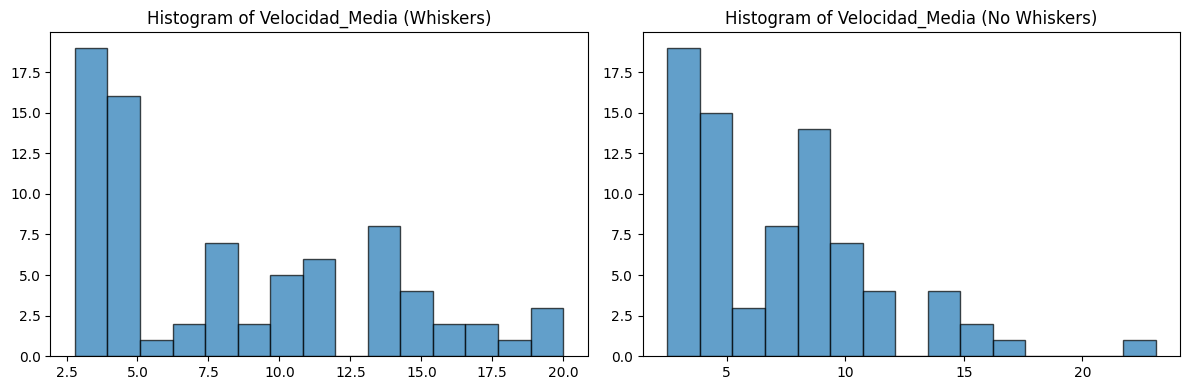

Normality test for Desviación_Estándar_de_la_Velocidad:


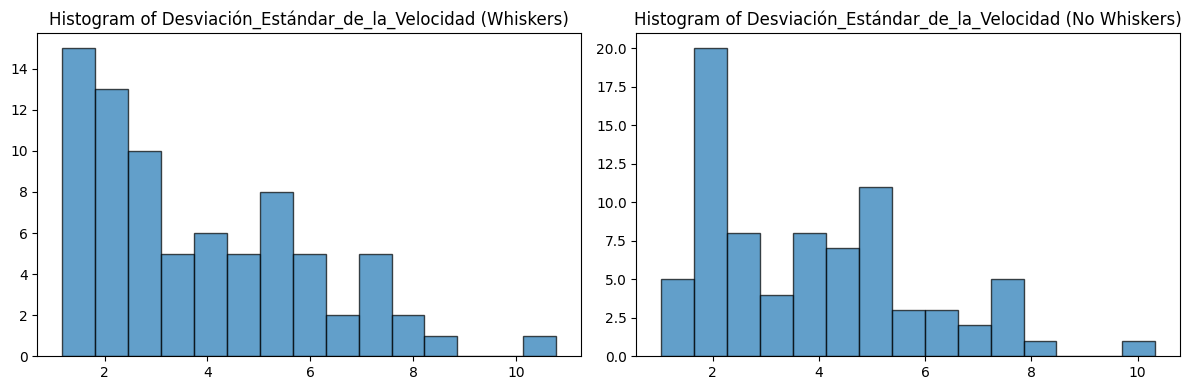

Normality test for Integral_de_la_Velocidad:


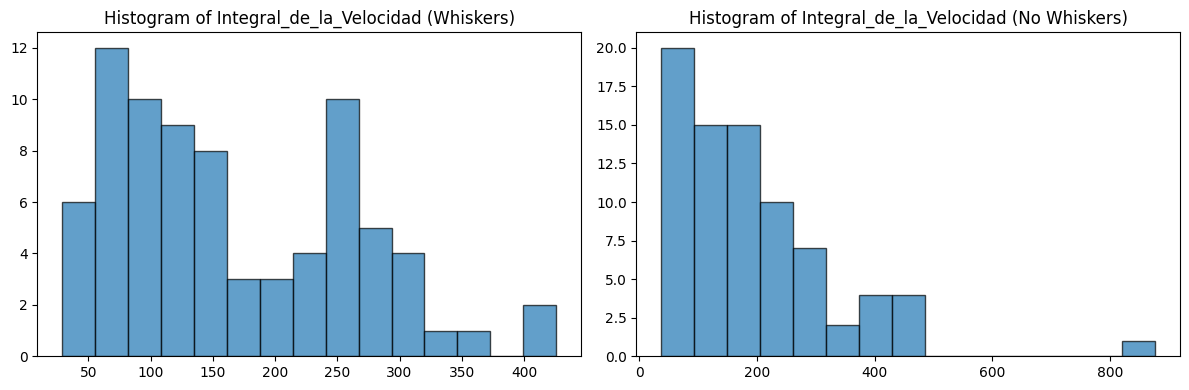

Normality test for Curvatura_Media:


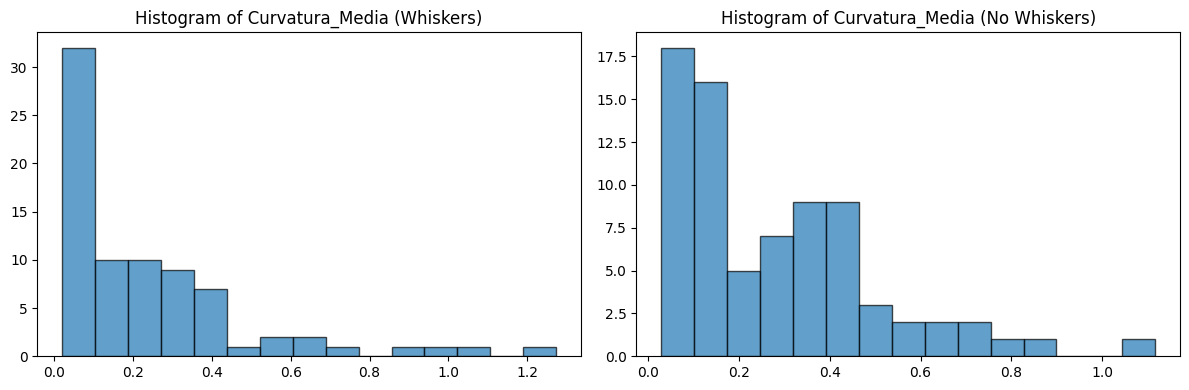

Normality test for Desviación_Estándar_de_la_Curvatura:


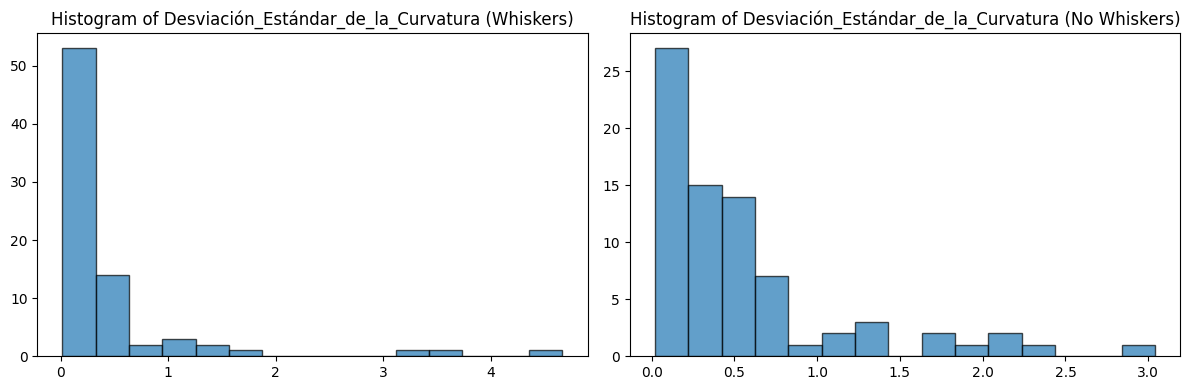

Normality test for Integral_de_la_Curvatura:


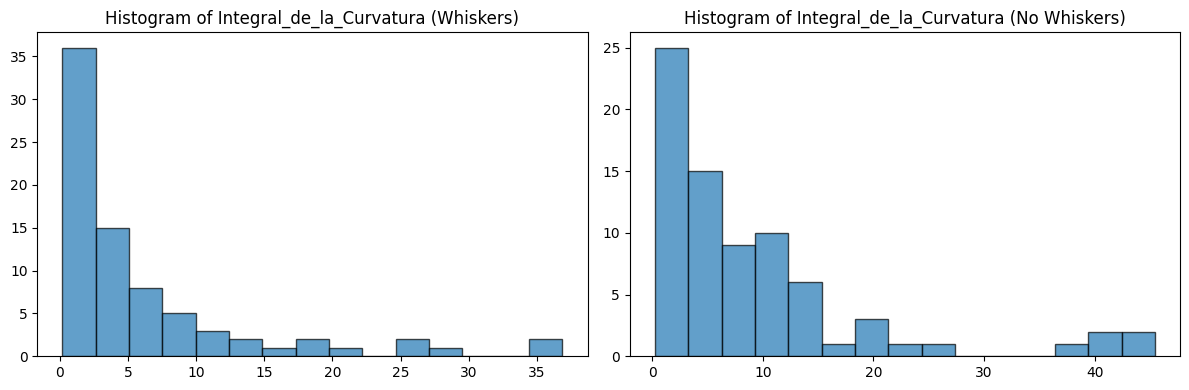

Normality test for Torsión_Media:


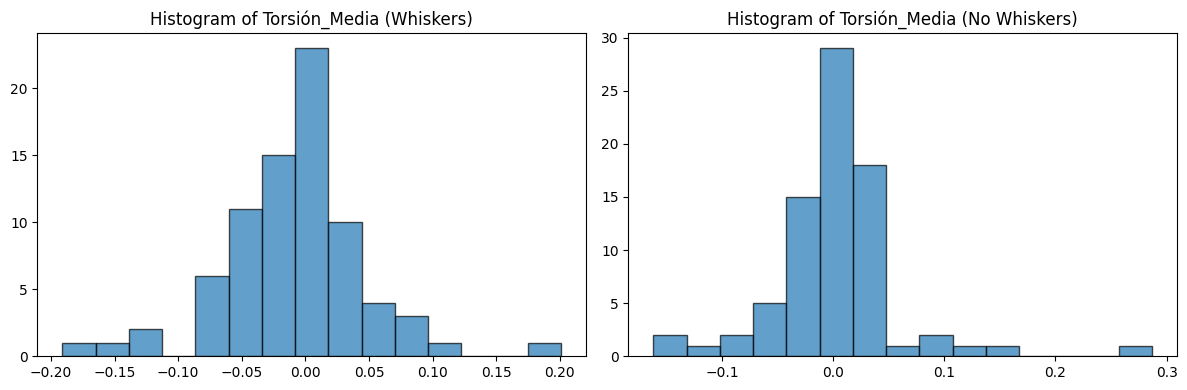

Normality test for Desviación_Estándar_de_la_Torsión:


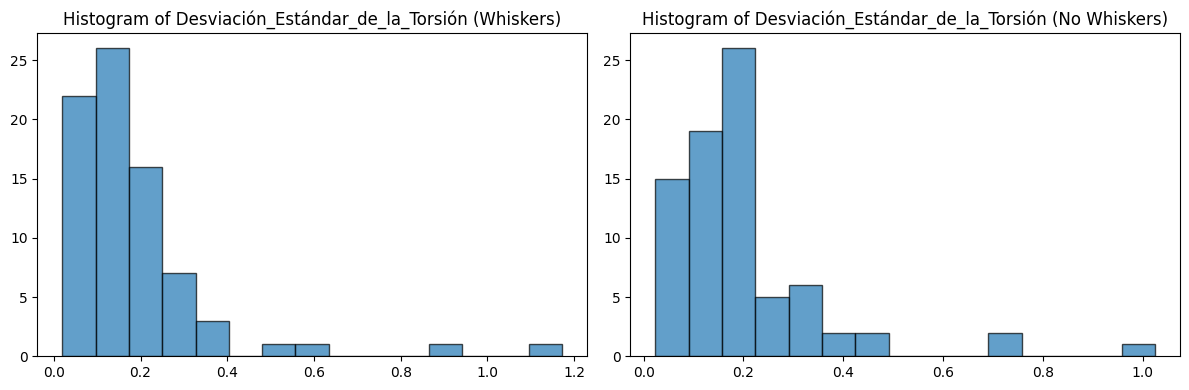

Normality test for Integral_de_la_Torsión:


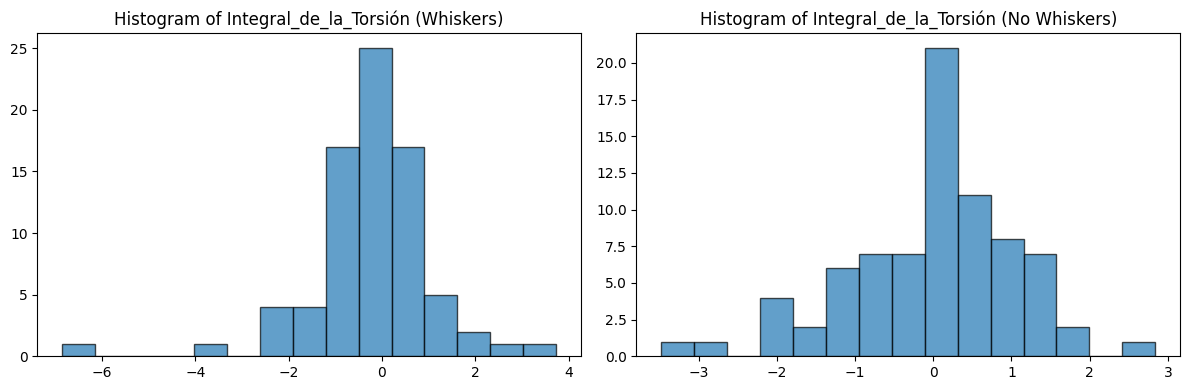

Normality test for Longitud_Total:


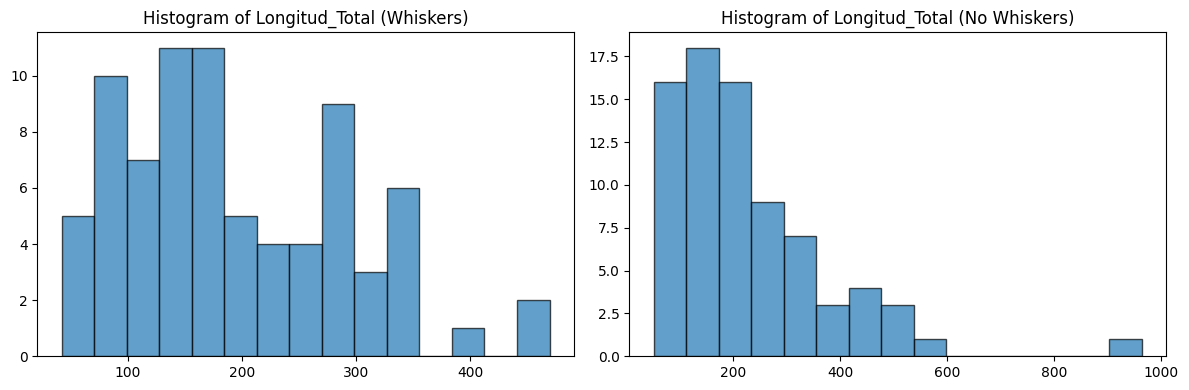

Normality test for Longitud_en_X:


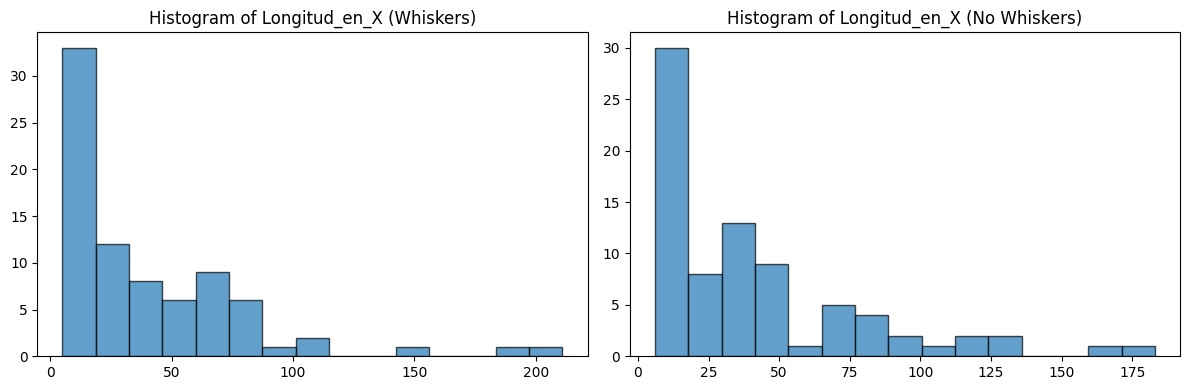

Normality test for Longitud_en_Y:


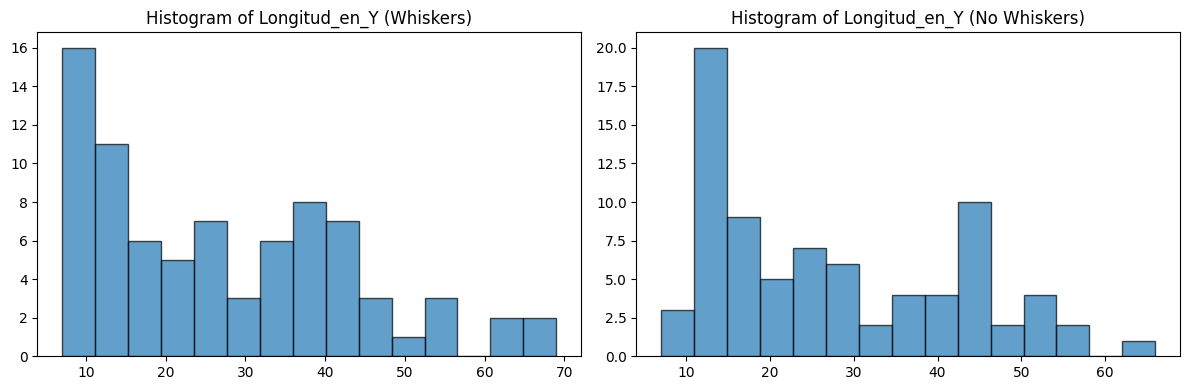

Normality test for Longitud_en_Z:


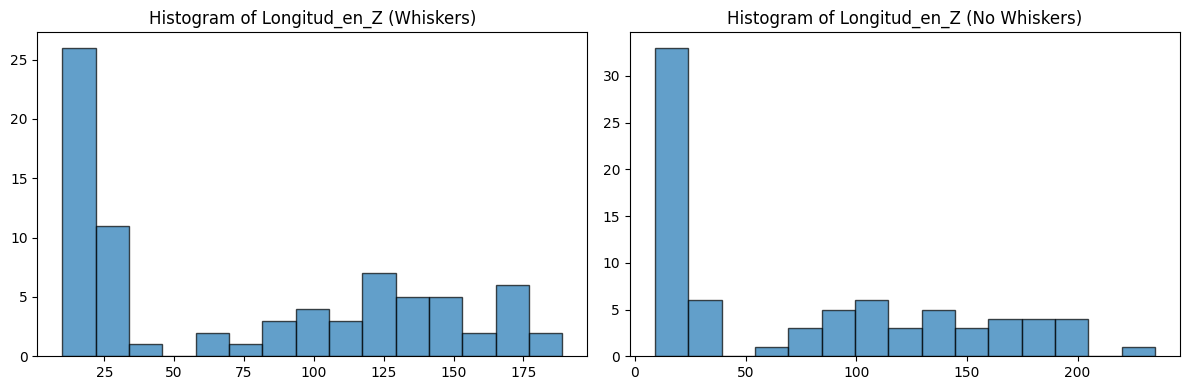

Normality test for Volumen:


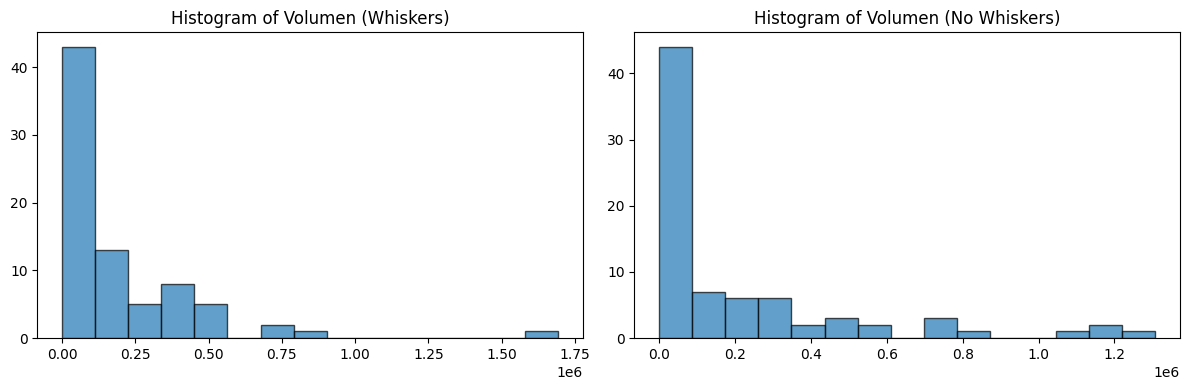

In [18]:
# Separate data based on "Tipo" (whiskers or no whiskers)
whiskers_data = data[data['Tipo'] == 'Whiskers']
no_whiskers_data = data[data['Tipo'] == 'No whiskers']

for metric in metrics:
    hist_plots(whiskers_data, no_whiskers_data, metric)

Modelo lineal mixto

In [19]:
for metric in metrics:
    print(f"Modelo lineal mixto para {metric}:")

    cleaned_data = data.dropna(subset=[metric, "Tipo"])

    # Re-attempt fitting the linear mixed effects model
    model = smf.mixedlm(f"{metric} ~ Tipo", cleaned_data, groups=cleaned_data["Individuo"])
    result = model.fit()

    # Summarize the results of the mixed effects model
    display(result.summary())

Modelo lineal mixto para Velocidad_Media:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                 MixedLM     Dependent Variable:     Velocidad_Media
No. Observations:      156         Method:                 REML           
No. Groups:            4           Scale:                  19.7590        
Min. group size:       38          Log-Likelihood:         inf            
Max. group size:       41          Converged:              Yes            
Mean group size:       39.0                                               
--------------------------------------------------------------------------
                 Coef.   Std.Err.     z   P>|z|     [0.025       0.975]   
--------------------------------------------------------------------------
Intercept        0.000 35155733.788 0.000 1.000 -68903972.074 68903972.074
Tipo[T.Whiskers] 1.220        0.712 1.714 0.087        -0.175        2.615
Group Var        0.000                                                    
==========================================================================

"""

Modelo lineal mixto para Desviación_Estándar_de_la_Velocidad:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Velocidad
No. Observations: 156     Method:             REML                               
No. Groups:       4       Scale:              4.2481                             
Min. group size:  38      Log-Likelihood:     inf                                
Max. group size:  41      Converged:          Yes                                
Mean group size:  39.0                                                           
----------------------------------------------------------------------------------
                    Coef.    Std.Err.      z    P>|z|      [0.025        0.975]   
----------------------------------------------------------------------------------
Intercept           0.000  16300830.170  0.000  1.000  -31949040.051  31949040.051
Tipo[T.Whiskers]    0.008         0.330  0.023  0.982         -0.639         0.654
Group Var           0.000                                                         
=================================================================================

"""

Modelo lineal mixto para Integral_de_la_Velocidad:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: Integral_de_la_Velocidad
No. Observations: 156     Method:             REML                    
No. Groups:       4       Scale:              13772.7955              
Min. group size:  38      Log-Likelihood:     -957.5208               
Max. group size:  41      Converged:          No                      
Mean group size:  39.0                                                
-----------------------------------------------------------------------
                      Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
-----------------------------------------------------------------------
Intercept            194.371    15.465  12.569  0.000  164.061  224.682
Tipo[T.Whiskers]     -28.548    18.795  -1.519  0.129  -65.385    8.289
Group Var            250.104     3.520                                 
======================================================================

"""

Modelo lineal mixto para Curvatura_Media:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Curvatura_Media
No. Observations: 154     Method:             REML           
No. Groups:       4       Scale:              0.0570         
Min. group size:  37      Log-Likelihood:     -3.2575        
Max. group size:  41      Converged:          Yes            
Mean group size:  38.5                                       
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.282    0.033  8.619 0.000  0.218  0.347
Tipo[T.Whiskers]   -0.044    0.038 -1.152 0.249 -0.120  0.031
Group Var           0.001    0.009                           
=============================================================

"""

Modelo lineal mixto para Desviación_Estándar_de_la_Curvatura:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Curvatura
No. Observations: 154     Method:             REML                               
No. Groups:       4       Scale:              0.4617                             
Min. group size:  37      Log-Likelihood:     -163.1176                          
Max. group size:  41      Converged:          Yes                                
Mean group size:  38.5                                                           
-------------------------------------------------------------------------------------
                       Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-------------------------------------------------------------------------------------
Intercept               0.567        0.115      4.916     0.000      0.341      0.792
Tipo[T.Whiskers]       -0.117        0.110     -1.065     0.287     -0.331      0.098
Group Var               0.029        0.050                                           
=================================================================================

"""

Modelo lineal mixto para Integral_de_la_Curvatura:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: Integral_de_la_Curvatura
No. Observations: 154     Method:             REML                    
No. Groups:       4       Scale:              82.3734                 
Min. group size:  37      Log-Likelihood:     -556.9793               
Max. group size:  41      Converged:          Yes                     
Mean group size:  38.5                                                
------------------------------------------------------------------------
                    Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
------------------------------------------------------------------------
Intercept            9.125      1.488    6.134   0.000    6.209   12.040
Tipo[T.Whiskers]    -2.977      1.463   -2.035   0.042   -5.845   -0.110
Group Var            4.514      0.609                                   
======================================================================

"""

Modelo lineal mixto para Torsión_Media:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM    Dependent Variable:    Torsión_Media
No. Observations:      156        Method:                REML         
No. Groups:            4          Scale:                 0.0031       
Min. group size:       38         Log-Likelihood:        inf          
Max. group size:       41         Converged:             Yes          
Mean group size:       39.0                                           
----------------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
----------------------------------------------------------------------
Intercept        -0.000 439970.900 -0.000 1.000 -862327.119 862327.119
Tipo[T.Whiskers] -0.011      0.009 -1.213 0.225      -0.028      0.007
Group Var         0.000                                               
======================================================================

"""

Modelo lineal mixto para Desviación_Estándar_de_la_Torsión:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Torsión
No. Observations: 156     Method:             REML                             
No. Groups:       4       Scale:              0.0276                           
Min. group size:  38      Log-Likelihood:     inf                              
Max. group size:  41      Converged:          Yes                              
Mean group size:  39.0                                                         
--------------------------------------------------------------------------------
                   Coef.     Std.Err.     z     P>|z|     [0.025        0.975]  
--------------------------------------------------------------------------------
Intercept          -0.000  1314881.075  -0.000  1.000  -2577119.550  2577119.550
Tipo[T.Whiskers]   -0.016        0.027  -0.592  0.554        -0.068        0.036
Group Var           0.000                                                       
===============================================================================

"""

Modelo lineal mixto para Integral_de_la_Torsión:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:               MixedLM   Dependent Variable:   Integral_de_la_Torsión
No. Observations:    156       Method:               REML                  
No. Groups:          4         Scale:                1.4534                
Min. group size:     38        Log-Likelihood:       inf                   
Max. group size:     41        Converged:            Yes                   
Mean group size:     39.0                                                  
---------------------------------------------------------------------------
                 Coef.    Std.Err.    z    P>|z|     [0.025       0.975]   
---------------------------------------------------------------------------
Intercept        -0.000 9534765.028 -0.000 1.000 -18687796.056 18687796.056
Tipo[T.Whiskers] -0.229       0.193 -1.184 0.236        -0.607        0.150
Group Var         0.000                                                    
===========================================================================

"""

Modelo lineal mixto para Longitud_Total:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM Dependent Variable: Longitud_Total
No. Observations:   156     Method:             REML          
No. Groups:         4       Scale:              15484.3488    
Min. group size:    38      Log-Likelihood:     -967.2187     
Max. group size:    41      Converged:          Yes           
Mean group size:    39.0                                      
--------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        227.307   19.129 11.883 0.000 189.816 264.799
Tipo[T.Whiskers] -33.486   19.929 -1.680 0.093 -72.546   5.575
Group Var        669.314    7.081                             
==============================================================

"""

Modelo lineal mixto para Longitud_en_X:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:              MixedLM Dependent Variable: Longitud_en_X
No. Observations:   159     Method:             REML         
No. Groups:         4       Scale:              1371.9517    
Min. group size:    38      Log-Likelihood:     -797.0472    
Max. group size:    42      Converged:          No           
Mean group size:    39.8                                     
-------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------
Intercept         41.477    8.072  5.138 0.000  25.656 57.297
Tipo[T.Whiskers]  -0.973    5.875 -0.166 0.868 -12.488 10.542
Group Var        191.089    7.183                            
=============================================================

"""

Modelo lineal mixto para Longitud_en_Y:


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Longitud_en_Y
No. Observations: 159     Method:             REML         
No. Groups:       4       Scale:              221.6112     
Min. group size:  38      Log-Likelihood:     -653.6088    
Max. group size:  42      Converged:          No           
Mean group size:  39.8                                     
-----------------------------------------------------------
                  Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         27.395    2.955 9.269 0.000 21.602 33.188
Tipo[T.Whiskers]   0.259    2.361 0.110 0.913 -4.369  4.887
Group Var         23.711    1.430                          
===========================================================

"""

Modelo lineal mixto para Longitud_en_Z:


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:             MixedLM Dependent Variable: Longitud_en_Z
No. Observations:  156     Method:             REML         
No. Groups:        4       Scale:              3929.8573    
Min. group size:   38      Log-Likelihood:     -861.1105    
Max. group size:   41      Converged:          Yes          
Mean group size:   39.0                                     
------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------
Intercept        76.902    8.539  9.006 0.000  60.166 93.638
Tipo[T.Whiskers] -1.276   10.039 -0.127 0.899 -20.953 18.401
Group Var        90.087    3.127                            
============================================================

"""

Modelo lineal mixto para Volumen:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                 MixedLM      Dependent Variable:      Volumen         
No. Observations:      156          Method:                  REML            
No. Groups:            4            Scale:                   81127558501.7978
Min. group size:       38           Log-Likelihood:          -2157.9727      
Max. group size:       41           Converged:               No              
Mean group size:       39.0                                                  
-----------------------------------------------------------------------------
                     Coef.       Std.Err.   z    P>|z|    [0.025     0.975]  
-----------------------------------------------------------------------------
Intercept            197605.764 38435.633  5.141 0.000  122273.308 272938.220
Tipo[T.Whiskers]     -20690.167 45616.658 -0.454 0.650 -110097.174  68716.840
Group Var        1747369904.723 11853.710                                    
=============================================================================

"""

Prueba no paramétrica de Wilcoxon

In [20]:
for metric in metrics:
    print(f"Wilcoxon para {metric}:")

    paired_data = cleaned_data.pivot_table(index="Individuo", columns="Tipo", values=metric)

    wilcoxon_test_result = wilcoxon(paired_data["Whiskers"], paired_data["No whiskers"])

    print(wilcoxon_test_result)

Wilcoxon para Velocidad_Media:
WilcoxonResult(statistic=1.0, pvalue=0.25)
Wilcoxon para Desviación_Estándar_de_la_Velocidad:
WilcoxonResult(statistic=5.0, pvalue=1.0)
Wilcoxon para Integral_de_la_Velocidad:
WilcoxonResult(statistic=0.0, pvalue=0.125)
Wilcoxon para Curvatura_Media:
WilcoxonResult(statistic=3.0, pvalue=0.625)
Wilcoxon para Desviación_Estándar_de_la_Curvatura:
WilcoxonResult(statistic=2.0, pvalue=0.375)
Wilcoxon para Integral_de_la_Curvatura:
WilcoxonResult(statistic=0.0, pvalue=0.125)
Wilcoxon para Torsión_Media:
WilcoxonResult(statistic=0.0, pvalue=0.125)
Wilcoxon para Desviación_Estándar_de_la_Torsión:
WilcoxonResult(statistic=4.0, pvalue=0.875)
Wilcoxon para Integral_de_la_Torsión:
WilcoxonResult(statistic=0.0, pvalue=0.125)
Wilcoxon para Longitud_Total:
WilcoxonResult(statistic=1.0, pvalue=0.25)
Wilcoxon para Longitud_en_X:
WilcoxonResult(statistic=5.0, pvalue=1.0)
Wilcoxon para Longitud_en_Y:
WilcoxonResult(statistic=5.0, pvalue=1.0)
Wilcoxon para Longitud_en_Z:
Wil

## Análisis comparativo con pedicelo

In [21]:
# Leo el archivo de datos
data = pd.read_excel('data/mediciones.xlsx')

display(data.head())

,Individuo,Tipo,No. Vuelo,Velocidad Media,Desviación Estándar de la Velocidad,Integral de la Velocidad,Curvatura Media,Desviación Estándar de la Curvatura,Integral de la Curvatura,Torsión Media,Desviación Estándar de la Torsión,Integral de la Torsión,Longitud Total,Longitud en X,Longitud en Y,Longitud en Z,Volumen
0,6,Whiskers,1,3.685155,2.469856,62.346961,0.319137,0.309382,5.333128,-0.025381,0.120565,-0.422220,75.694841,18,14,19.0,4788.0
1,6,Whiskers,10,8.442801,5.213999,244.123139,0.061655,0.072966,1.756422,-0.022569,0.129216,-0.701873,260.010676,54,40,125.0,270000.0
2,6,Whiskers,11,3.832310,2.993198,62.419556,1.097282,3.454947,19.665025,-0.113609,0.256775,-2.043465,80.997540,7,21,18.0,2646.0
3,6,Whiskers,12,7.883429,3.940560,124.664154,0.128108,0.231968,2.129493,0.038921,0.102573,0.657215,131.251894,21,40,93.0,78120.0
4,6,Whiskers,13,3.654315,2.337232,47.331496,0.255117,0.302641,3.785561,0.012112,0.194771,0.167200,58.087628,10,11,16.0,1760.0


In [22]:
metrics = ['Velocidad Media', 'Desviación Estándar de la Velocidad', 'Integral de la Velocidad',
           'Curvatura Media', 'Desviación Estándar de la Curvatura', 'Integral de la Curvatura',
           'Torsión Media', 'Desviación Estándar de la Torsión', 'Integral de la Torsión',
           'Longitud Total', 'Longitud en X', 'Longitud en Y', 'Longitud en Z', 'Volumen']

data.columns = data.columns.str.replace(" ", "_")
metrics = [metric.replace(" ", "_") for metric in metrics]

### Estable

Normality test for Velocidad_Media:


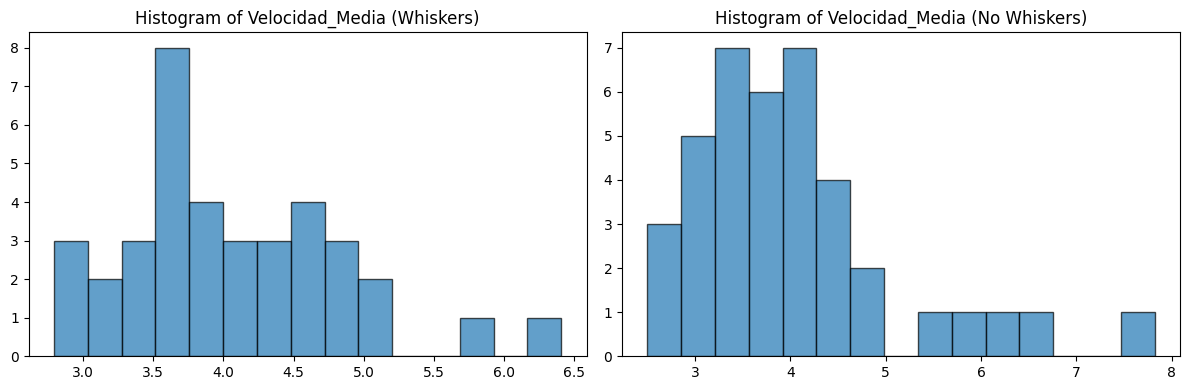

Normality test for Desviación_Estándar_de_la_Velocidad:


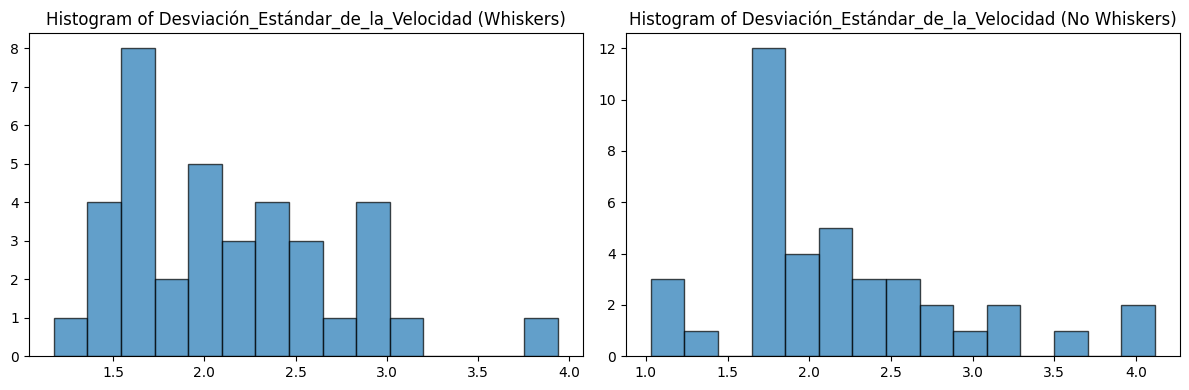

Normality test for Integral_de_la_Velocidad:


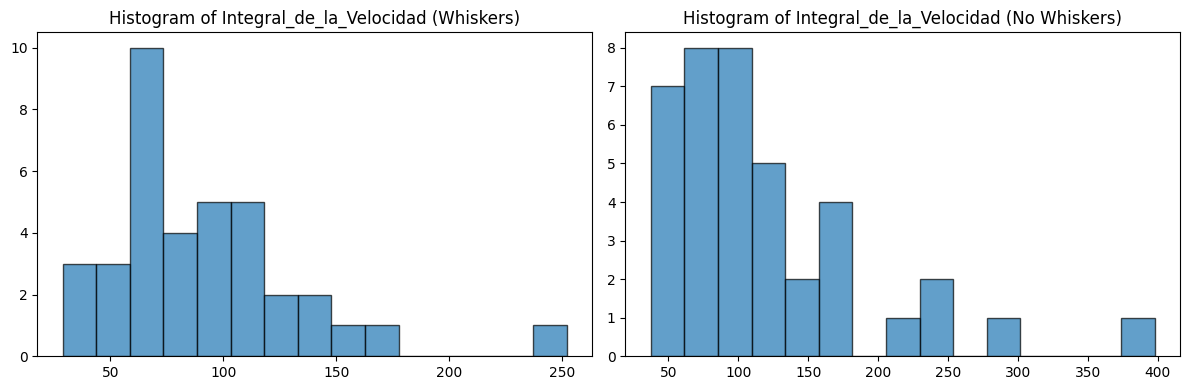

Normality test for Curvatura_Media:


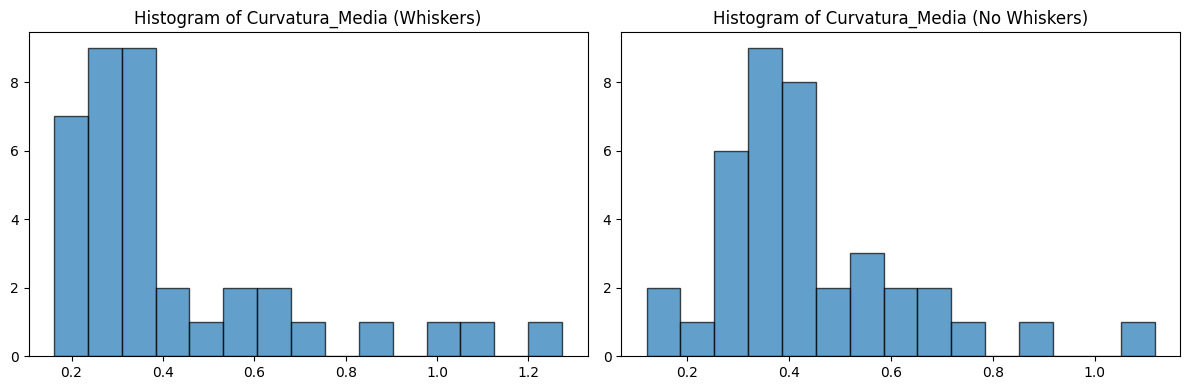

Normality test for Desviación_Estándar_de_la_Curvatura:


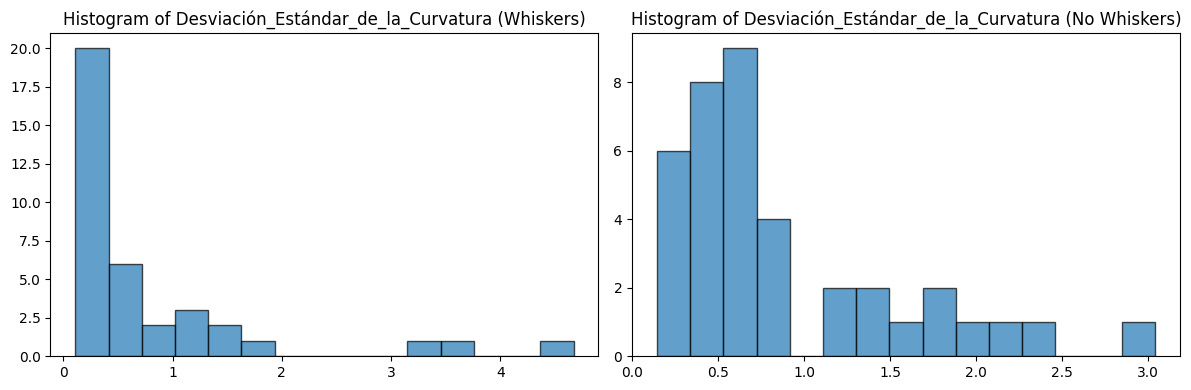

Normality test for Integral_de_la_Curvatura:


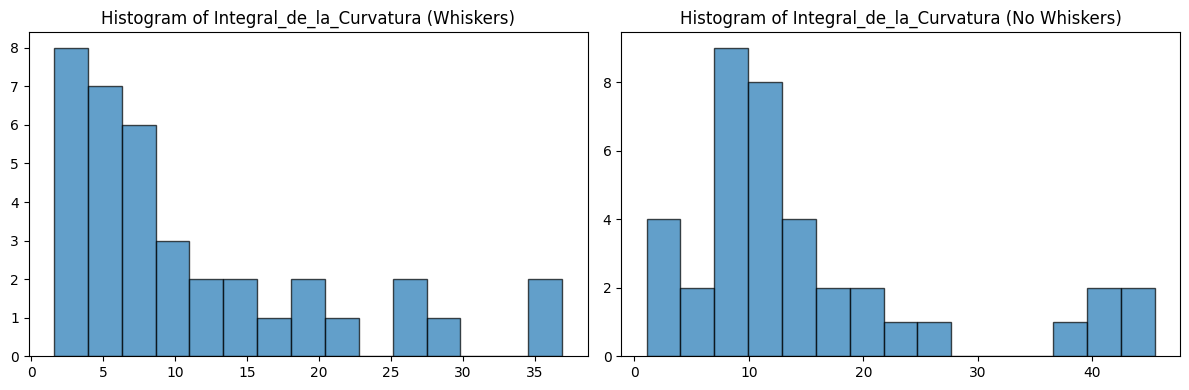

Normality test for Torsión_Media:


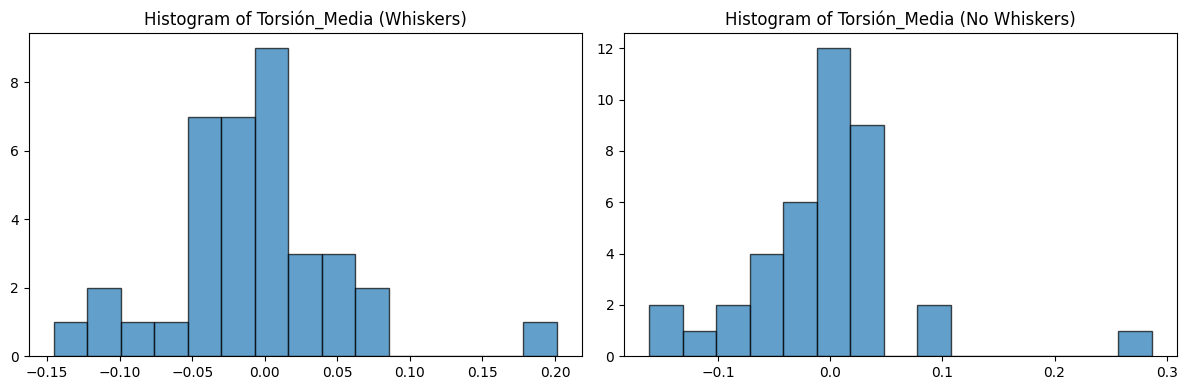

Normality test for Desviación_Estándar_de_la_Torsión:


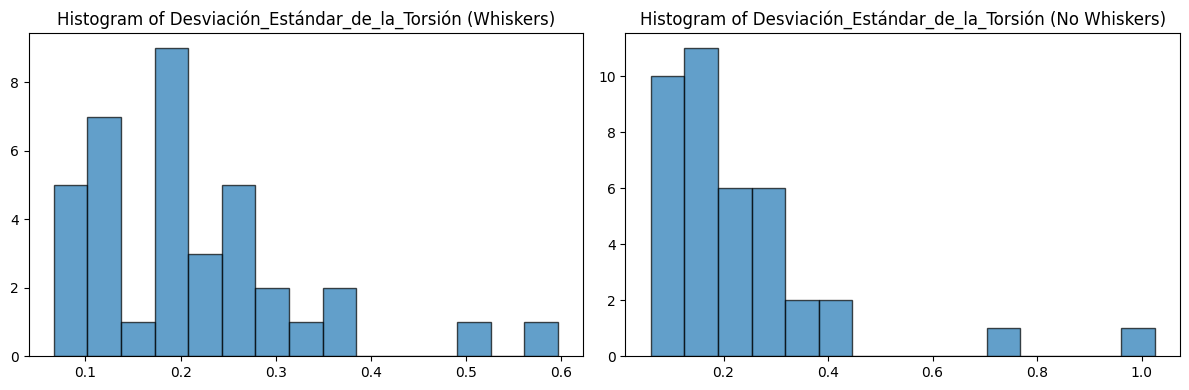

Normality test for Integral_de_la_Torsión:


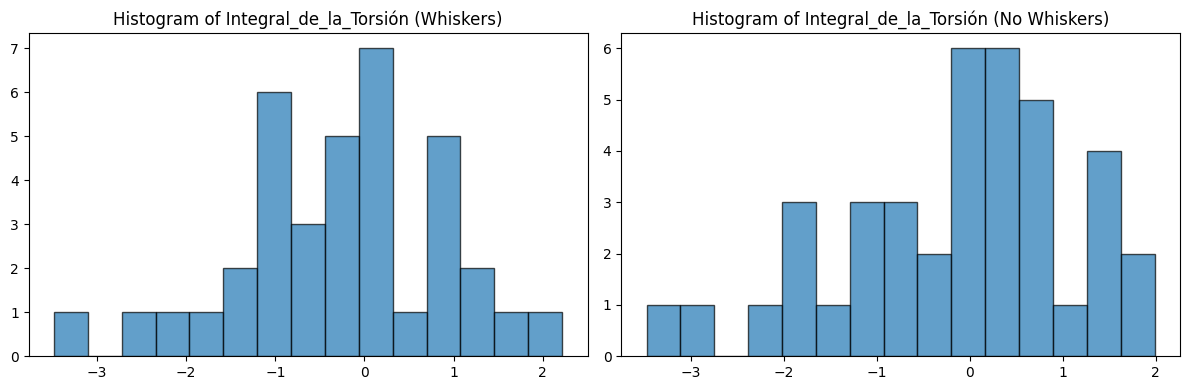

Normality test for Longitud_Total:


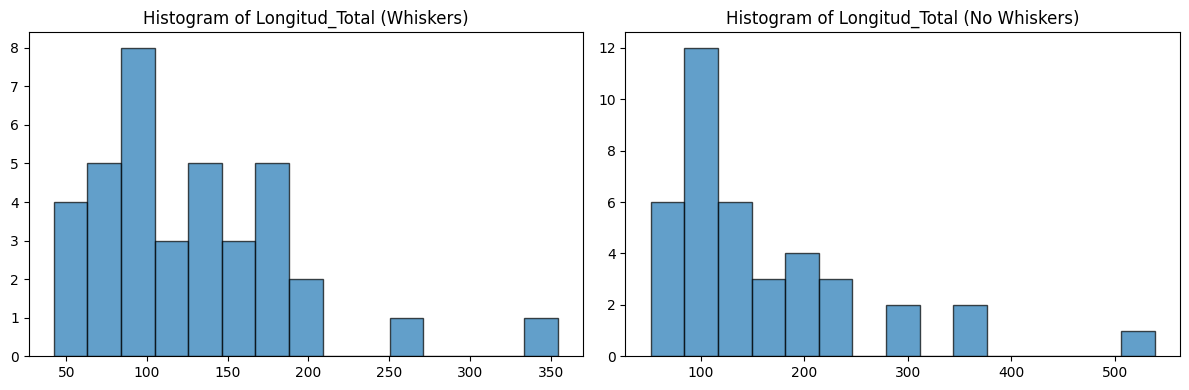

Normality test for Longitud_en_X:


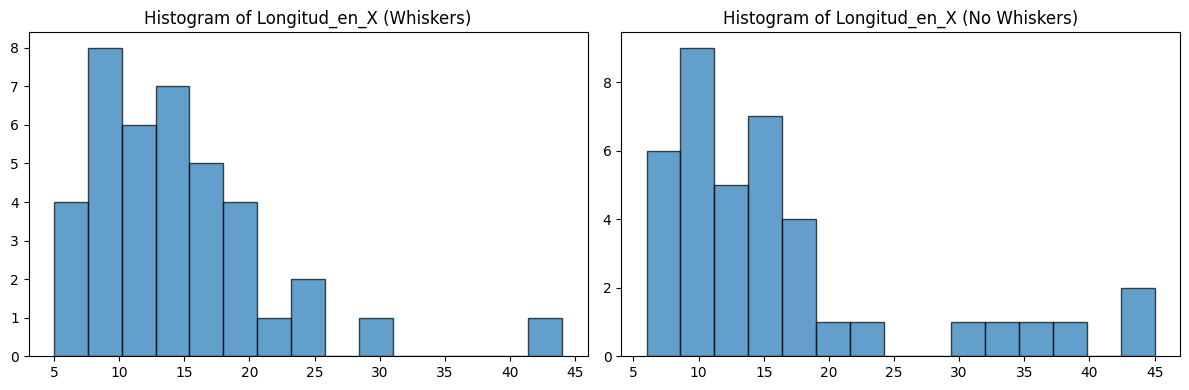

Normality test for Longitud_en_Y:


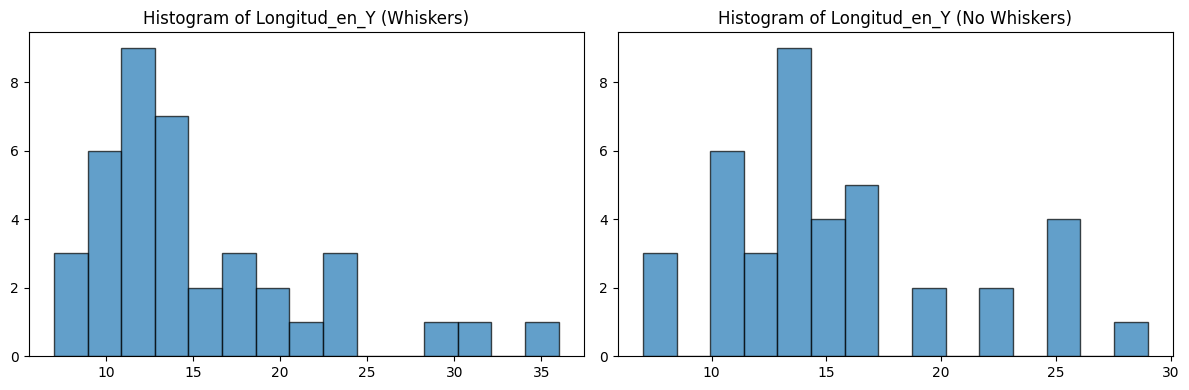

Normality test for Longitud_en_Z:


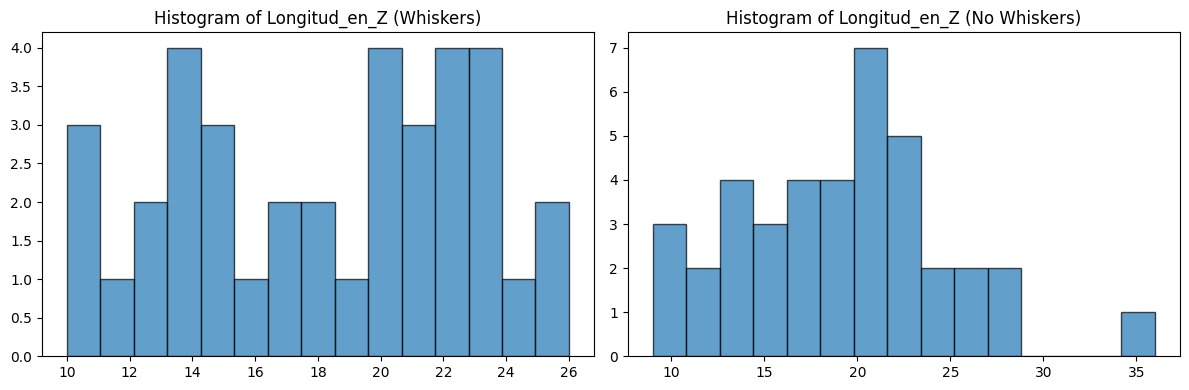

Normality test for Volumen:


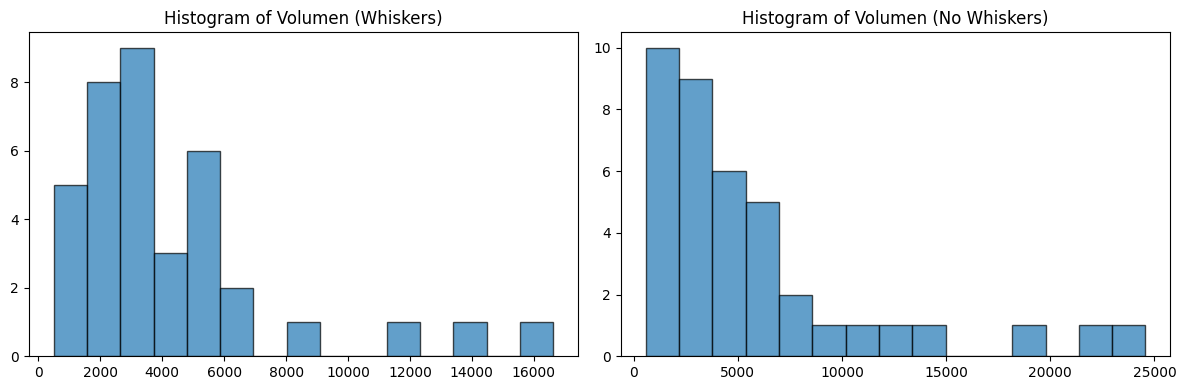

In [23]:
# Data estables, numéro de vuelo impares
data_estable = data[data['No._Vuelo'].astype(int) % 2 == 1]

# Separate data based on "Tipo" (whiskers or no whiskers)
whiskers_data = data_estable[data_estable['Tipo'] == 'Whiskers']
no_whiskers_data = data_estable[data_estable['Tipo'] == 'No whiskers']

for metric in metrics:
    hist_plots(whiskers_data, no_whiskers_data, metric)

In [24]:
for metric in metrics:
    print(f"Modelo lineal mixto para {metric}:")

    cleaned_data = data_estable.dropna(subset=[metric, "Tipo"])

    # Re-attempt fitting the linear mixed effects model
    model = smf.mixedlm(f"{metric} ~ Tipo", cleaned_data, groups=cleaned_data["Individuo"])
    result = model.fit()

    # Summarize the results of the mixed effects model
    display(result.summary())

Modelo lineal mixto para Velocidad_Media:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Velocidad_Media
No. Observations: 76      Method:             REML           
No. Groups:       4       Scale:              0.8658         
Min. group size:  18      Log-Likelihood:     -105.0549      
Max. group size:  21      Converged:          Yes            
Mean group size:  19.0                                       
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           4.037    0.218 18.531 0.000  3.610  4.464
Tipo[T.Whiskers]    0.039    0.214  0.182 0.855 -0.380  0.458
Group Var           0.101    0.131                           
=============================================================

"""

Modelo lineal mixto para Desviación_Estándar_de_la_Velocidad:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Velocidad
No. Observations: 76      Method:             REML                               
No. Groups:       4       Scale:              0.4284                             
Min. group size:  18      Log-Likelihood:     -78.2391                           
Max. group size:  21      Converged:          Yes                                
Mean group size:  19.0                                                           
-------------------------------------------------------------------------------------
                       Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-------------------------------------------------------------------------------------
Intercept               2.189        0.127     17.248     0.000      1.940      2.438
Tipo[T.Whiskers]       -0.059        0.150     -0.395     0.693     -0.354      0.235
Group Var               0.020        0.053                                           
=================================================================================

"""

Modelo lineal mixto para Integral_de_la_Velocidad:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: Integral_de_la_Velocidad
No. Observations: 76      Method:             REML                    
No. Groups:       4       Scale:              3460.5203               
Min. group size:  18      Log-Likelihood:     -412.2263               
Max. group size:  21      Converged:          Yes                     
Mean group size:  19.0                                                
-----------------------------------------------------------------------
                      Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
-----------------------------------------------------------------------
Intercept            119.397    14.986   7.967  0.000   90.026  148.769
Tipo[T.Whiskers]     -28.192    13.505  -2.088  0.037  -54.660   -1.723
Group Var            542.332    10.291                                 
======================================================================

"""

Modelo lineal mixto para Curvatura_Media:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Curvatura_Media
No. Observations: 75      Method:             REML           
No. Groups:       4       Scale:              0.0516         
Min. group size:  18      Log-Likelihood:     -0.5880        
Max. group size:  21      Converged:          Yes            
Mean group size:  18.8                                       
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.447    0.051  8.723 0.000  0.346  0.547
Tipo[T.Whiskers]   -0.023    0.052 -0.445 0.656 -0.126  0.079
Group Var           0.005    0.029                           
=============================================================

"""

Modelo lineal mixto para Desviación_Estándar_de_la_Curvatura:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Curvatura
No. Observations: 75      Method:             REML                               
No. Groups:       4       Scale:              0.6743                             
Min. group size:  18      Log-Likelihood:     -94.6716                           
Max. group size:  21      Converged:          Yes                                
Mean group size:  18.8                                                           
-------------------------------------------------------------------------------------
                       Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-------------------------------------------------------------------------------------
Intercept               0.886        0.199      4.446     0.000      0.496      1.277
Tipo[T.Whiskers]       -0.079        0.190     -0.416     0.678     -0.451      0.293
Group Var               0.088        0.127                                           
=================================================================================

"""

Modelo lineal mixto para Integral_de_la_Curvatura:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: Integral_de_la_Curvatura
No. Observations: 75      Method:             REML                    
No. Groups:       4       Scale:              104.1398                
Min. group size:  18      Log-Likelihood:     -278.5086               
Max. group size:  21      Converged:          Yes                     
Mean group size:  18.8                                                
------------------------------------------------------------------------
                    Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
------------------------------------------------------------------------
Intercept           15.095      2.403    6.281   0.000   10.385   19.805
Tipo[T.Whiskers]    -4.038      2.357   -1.713   0.087   -8.658    0.582
Group Var           12.109      1.461                                   
======================================================================

"""

Modelo lineal mixto para Torsión_Media:


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Torsión_Media
No. Observations: 76      Method:             REML         
No. Groups:       4       Scale:              0.0043       
Min. group size:  18      Log-Likelihood:     inf          
Max. group size:  21      Converged:          Yes          
Mean group size:  19.0                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.000                                    
Tipo[T.Whiskers] -0.006    0.015 -0.398 0.691 -0.036  0.024
Group Var         0.000                                    
===========================================================

"""

Modelo lineal mixto para Desviación_Estándar_de_la_Torsión:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Torsión
No. Observations: 76      Method:             REML                             
No. Groups:       4       Scale:              0.0229                           
Min. group size:  18      Log-Likelihood:     inf                              
Max. group size:  21      Converged:          Yes                              
Mean group size:  19.0                                                         
-----------------------------------------------------------------------------------
                     Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-----------------------------------------------------------------------------------
Intercept             0.000                                                        
Tipo[T.Whiskers]     -0.016        0.035     -0.467     0.641     -0.084      0.052
Group Var             0.000                                                        
===============================================================================

"""

Modelo lineal mixto para Integral_de_la_Torsión:


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:            MixedLM Dependent Variable: Integral_de_la_Torsión
No. Observations: 76      Method:             REML                  
No. Groups:       4       Scale:              1.4990                
Min. group size:  18      Log-Likelihood:     -123.9807             
Max. group size:  21      Converged:          Yes                   
Mean group size:  19.0                                              
---------------------------------------------------------------------
                      Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept             -0.138     0.210  -0.657  0.511  -0.549   0.273
Tipo[T.Whiskers]      -0.135     0.281  -0.480  0.631  -0.686   0.416
Group Var              0.022     0.065                               
====================================================================

"""

Modelo lineal mixto para Longitud_Total:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM Dependent Variable: Longitud_Total
No. Observations:   76      Method:             REML          
No. Groups:         4       Scale:              6431.0519     
Min. group size:    18      Log-Likelihood:     -434.9764     
Max. group size:    21      Converged:          Yes           
Mean group size:    19.0                                      
--------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        159.421   19.476  8.186 0.000 121.249 197.593
Tipo[T.Whiskers] -32.251   18.409 -1.752 0.080 -68.333   3.831
Group Var        855.883   12.426                             
==============================================================

"""

Modelo lineal mixto para Longitud_en_X:


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Longitud_en_X
No. Observations: 78      Method:             REML         
No. Groups:       4       Scale:              44.8244      
Min. group size:  18      Log-Likelihood:     -260.5545    
Max. group size:  21      Converged:          Yes          
Mean group size:  19.5                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        16.806    3.538  4.750 0.000  9.872 23.741
Tipo[T.Whiskers] -2.041    1.517 -1.345 0.178 -5.014  0.932
Group Var        45.460    5.958                           
===========================================================

"""

Modelo lineal mixto para Longitud_en_Y:


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Longitud_en_Y
No. Observations: 78      Method:             REML         
No. Groups:       4       Scale:              27.3563      
Min. group size:  18      Log-Likelihood:     -240.8666    
Max. group size:  21      Converged:          Yes          
Mean group size:  19.5                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        15.704    2.071  7.582 0.000 11.644 19.763
Tipo[T.Whiskers] -0.448    1.185 -0.378 0.706 -2.770  1.875
Group Var        14.344    2.519                           
===========================================================

"""

Modelo lineal mixto para Longitud_en_Z:


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Longitud_en_Z
No. Observations: 76      Method:             REML         
No. Groups:       4       Scale:              25.0515      
Min. group size:  18      Log-Likelihood:     -228.9013    
Max. group size:  21      Converged:          Yes          
Mean group size:  19.0                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        18.961    0.998 19.002 0.000 17.005 20.917
Tipo[T.Whiskers] -0.785    1.149 -0.683 0.495 -3.036  1.467
Group Var         1.408    0.462                           
===========================================================

"""

Modelo lineal mixto para Volumen:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                MixedLM    Dependent Variable:    Volumen      
No. Observations:     76         Method:                REML         
No. Groups:           4          Scale:                 16163148.4069
Min. group size:      18         Log-Likelihood:        -726.5002    
Max. group size:      21         Converged:             Yes          
Mean group size:      19.0                                           
---------------------------------------------------------------------
                    Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
---------------------------------------------------------------------
Intercept           5906.737 1661.407  3.555 0.000  2650.438 9163.035
Tipo[T.Whiskers]   -1691.692  922.936 -1.833 0.067 -3500.613  117.229
Group Var        9377604.069 2127.946                                
=====================================================================

"""

### Flexible

Normality test for Velocidad_Media:


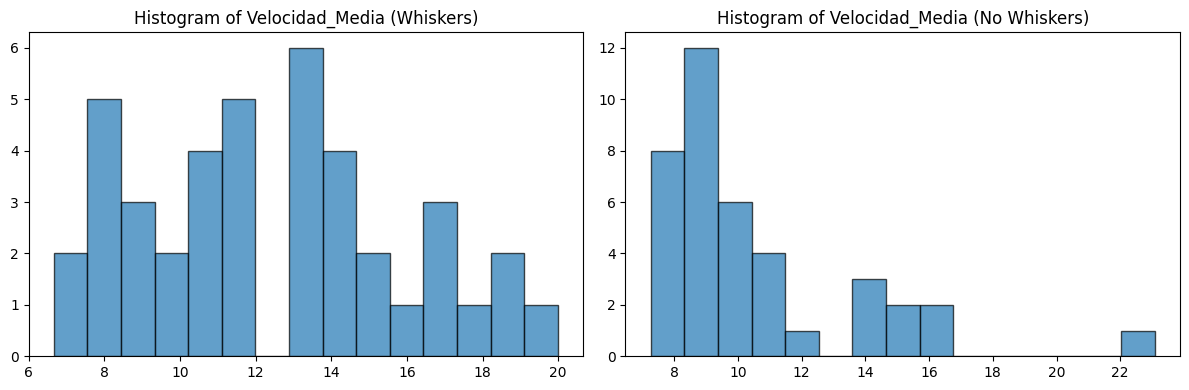

Normality test for Desviación_Estándar_de_la_Velocidad:


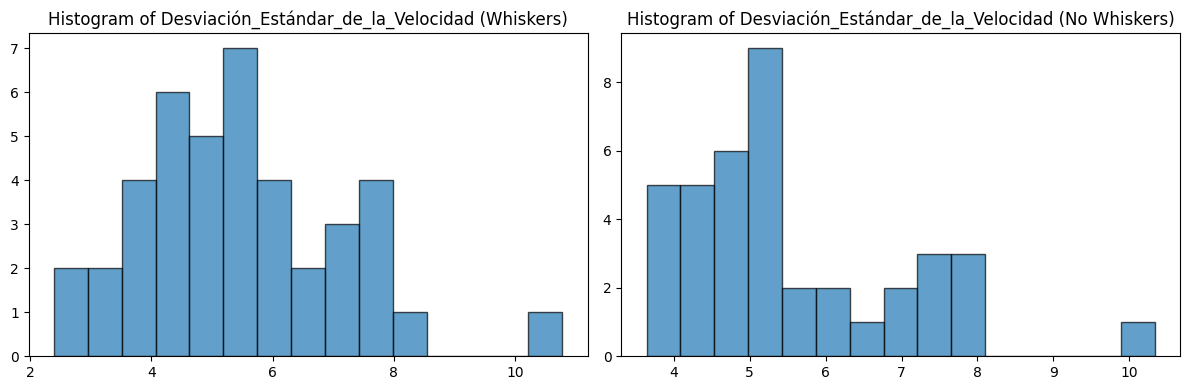

Normality test for Integral_de_la_Velocidad:


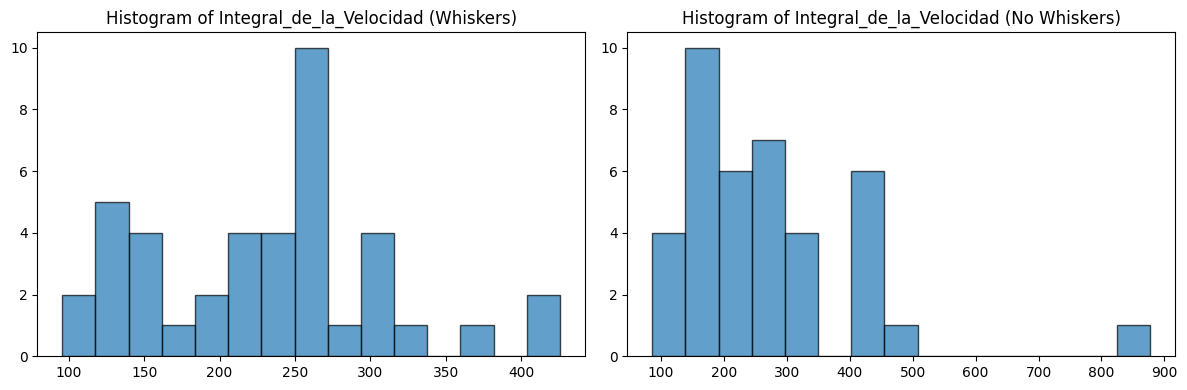

Normality test for Curvatura_Media:


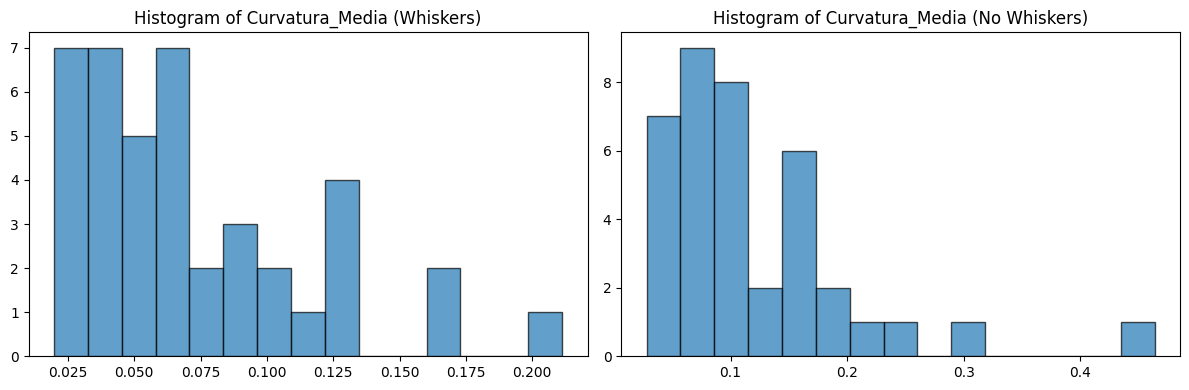

Normality test for Desviación_Estándar_de_la_Curvatura:


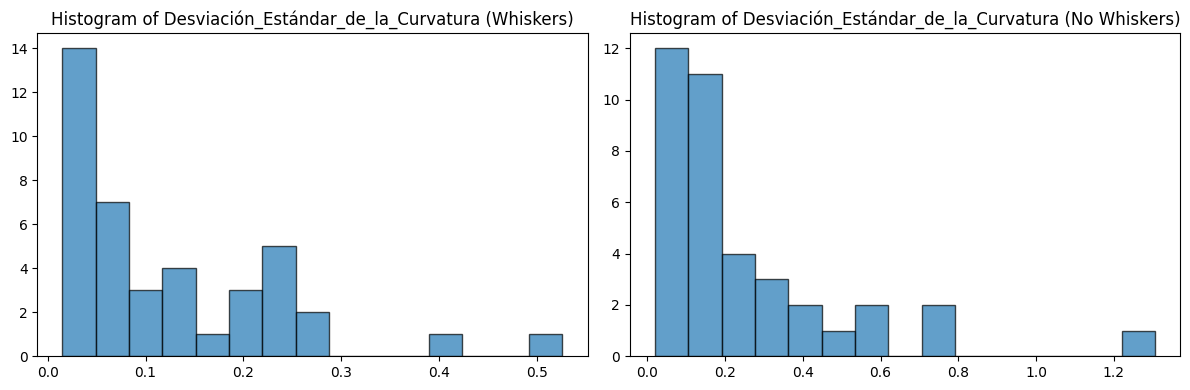

Normality test for Integral_de_la_Curvatura:


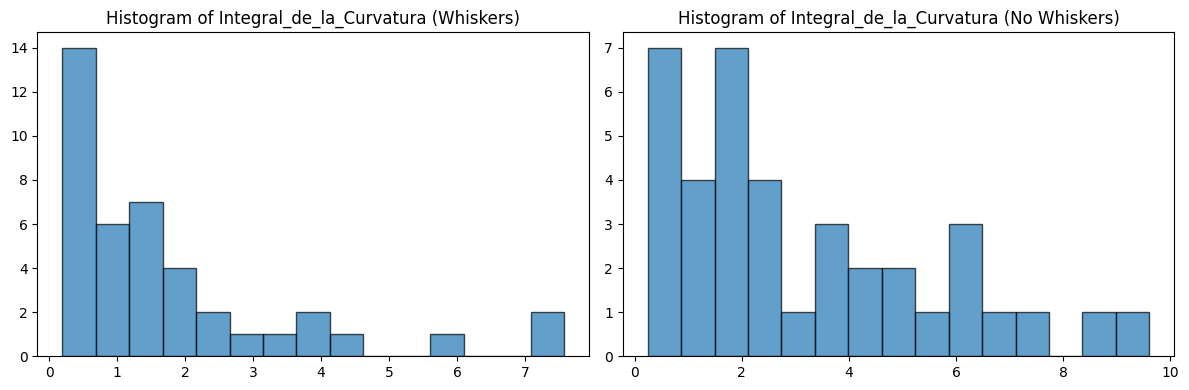

Normality test for Torsión_Media:


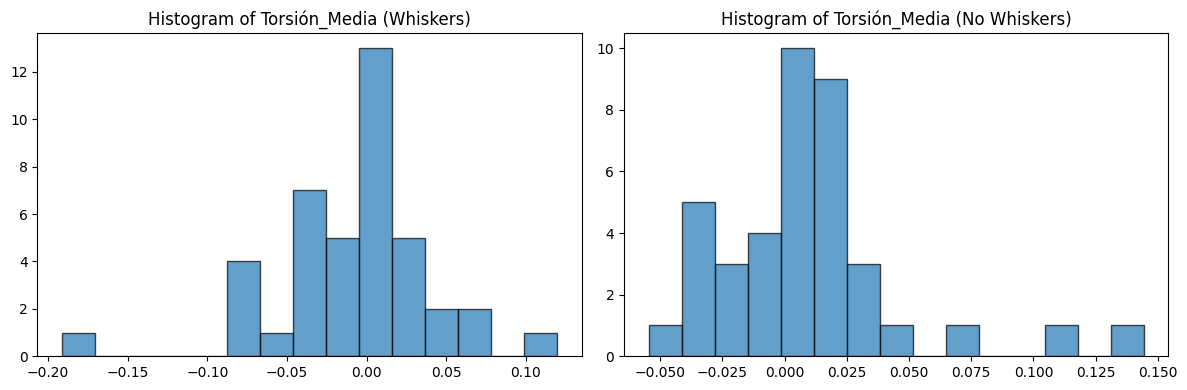

Normality test for Desviación_Estándar_de_la_Torsión:


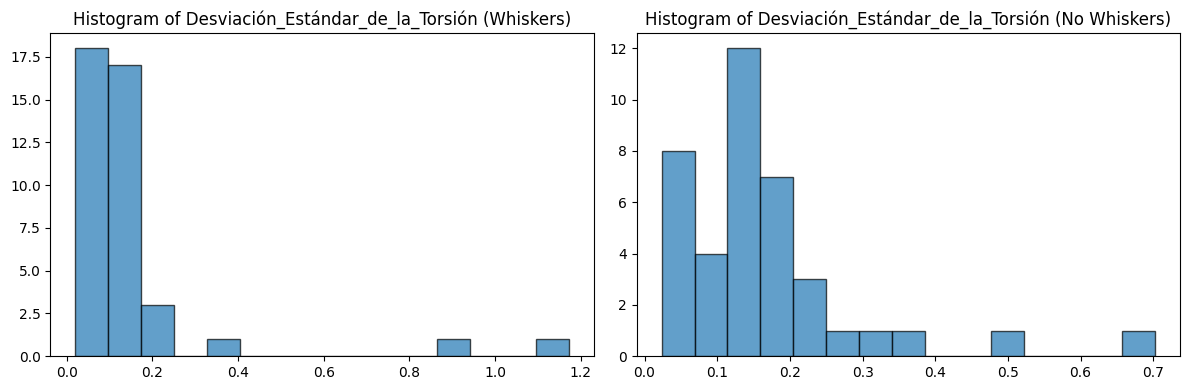

Normality test for Integral_de_la_Torsión:


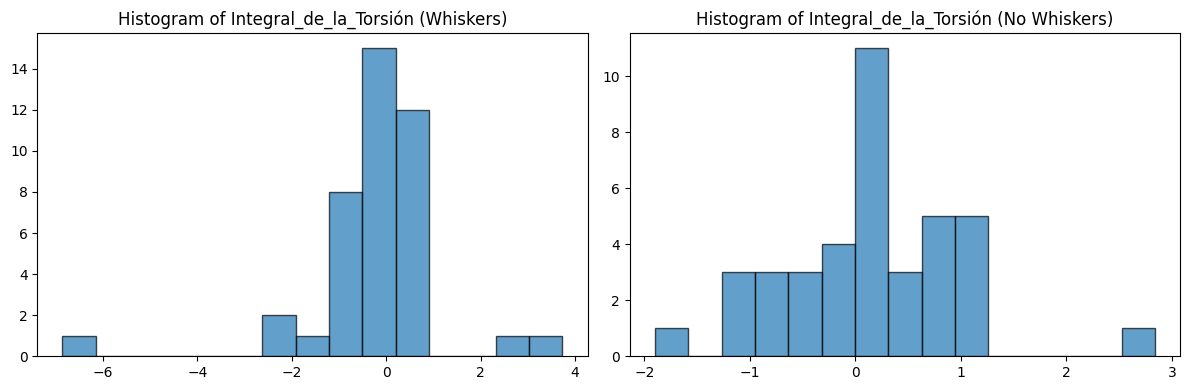

Normality test for Longitud_Total:


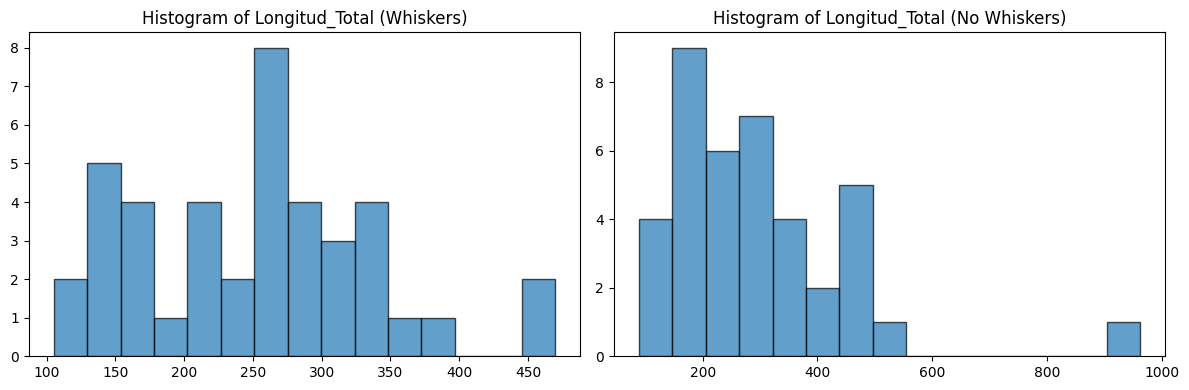

Normality test for Longitud_en_X:


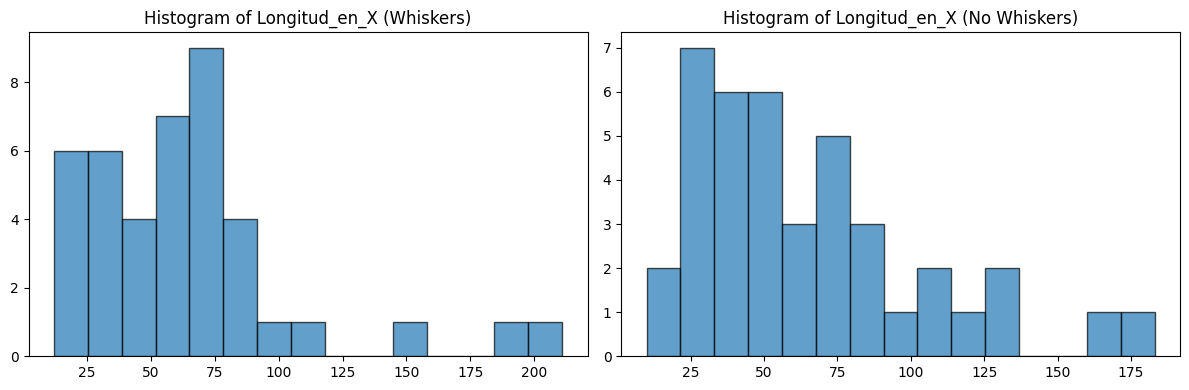

Normality test for Longitud_en_Y:


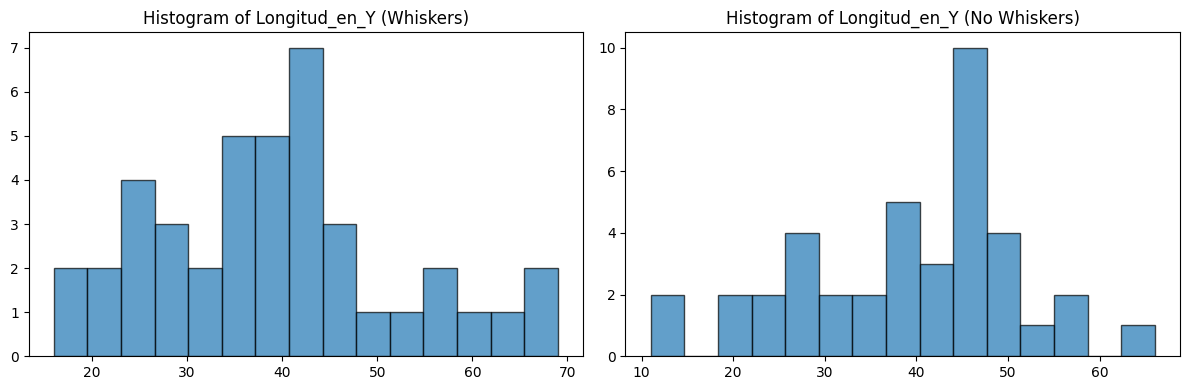

Normality test for Longitud_en_Z:


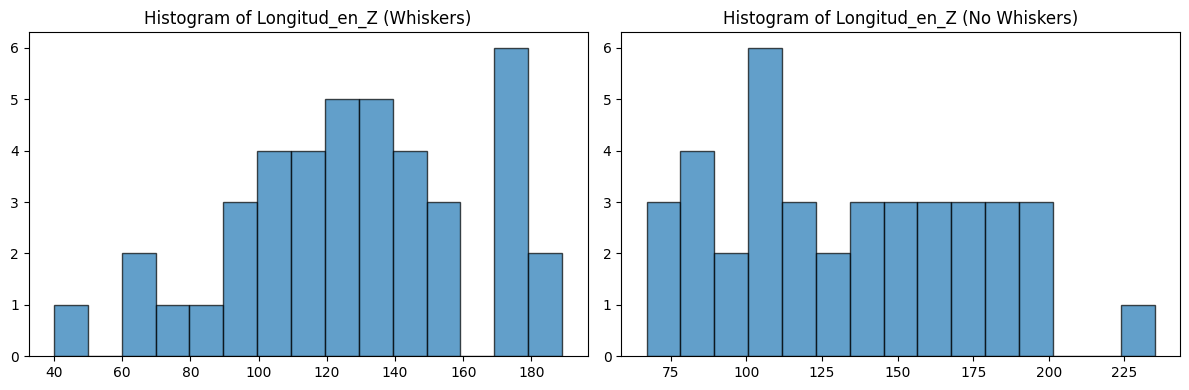

Normality test for Volumen:


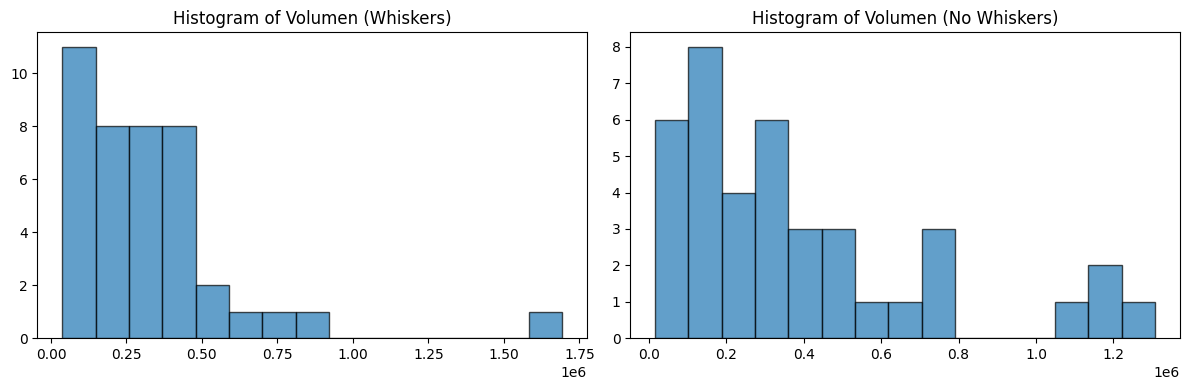

In [25]:
# Data estables, numéro de vuelo pares
data_flexible = data[data['No._Vuelo'].astype(int) % 2 == 0]

# Separate data based on "Tipo" (whiskers or no whiskers)
whiskers_data = data_flexible[data_flexible['Tipo'] == 'Whiskers']
no_whiskers_data = data_flexible[data_flexible['Tipo'] == 'No whiskers']

for metric in metrics:
    hist_plots(whiskers_data, no_whiskers_data, metric)

In [26]:
for metric in metrics:
    print(f"Modelo lineal mixto para {metric}:")

    cleaned_data = data_flexible.dropna(subset=[metric, "Tipo"])

    # Re-attempt fitting the linear mixed effects model
    model = smf.mixedlm(f"{metric} ~ Tipo", cleaned_data, groups=cleaned_data["Individuo"])
    result = model.fit()

    # Summarize the results of the mixed effects model
    display(result.summary())

Modelo lineal mixto para Velocidad_Media:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Velocidad_Media
No. Observations: 80      Method:             REML           
No. Groups:       4       Scale:              9.7541         
Min. group size:  20      Log-Likelihood:     -206.0630      
Max. group size:  20      Converged:          Yes            
Mean group size:  20.0                                       
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          10.494    0.976 10.747 0.000  8.580 12.408
Tipo[T.Whiskers]    1.957    0.699  2.799 0.005  0.587  3.328
Group Var           2.813    0.880                           
=============================================================

"""

Modelo lineal mixto para Desviación_Estándar_de_la_Velocidad:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Velocidad
No. Observations: 80      Method:             REML                               
No. Groups:       4       Scale:              2.5441                             
Min. group size:  20      Log-Likelihood:     -150.9914                          
Max. group size:  20      Converged:          No                                 
Mean group size:  20.0                                                           
-------------------------------------------------------------------------------------
                       Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-------------------------------------------------------------------------------------
Intercept               5.535        0.265     20.847     0.000      5.014      6.055
Tipo[T.Whiskers]       -0.111        0.360     -0.308     0.758     -0.815      0.594
Group Var               0.019        0.298                                           
=================================================================================

"""

Modelo lineal mixto para Integral_de_la_Velocidad:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: Integral_de_la_Velocidad
No. Observations: 80      Method:             REML                    
No. Groups:       4       Scale:              13319.9858              
Min. group size:  20      Log-Likelihood:     -484.7681               
Max. group size:  20      Converged:          No                      
Mean group size:  20.0                                                
-----------------------------------------------------------------------
                      Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
-----------------------------------------------------------------------
Intercept            269.336    18.537  14.530  0.000  233.004  305.667
Tipo[T.Whiskers]     -36.306    25.816  -1.406  0.160  -86.904   14.291
Group Var              8.269     4.601                                 
======================================================================

"""

Modelo lineal mixto para Curvatura_Media:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Curvatura_Media
No. Observations: 79      Method:             REML           
No. Groups:       4       Scale:              0.0040         
Min. group size:  19      Log-Likelihood:     97.6599        
Max. group size:  20      Converged:          Yes            
Mean group size:  19.8                                       
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.119    0.015  7.845 0.000  0.089  0.148
Tipo[T.Whiskers]   -0.047    0.014 -3.300 0.001 -0.075 -0.019
Group Var           0.000    0.009                           
=============================================================

"""

Modelo lineal mixto para Desviación_Estándar_de_la_Curvatura:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Curvatura
No. Observations: 79      Method:             REML                               
No. Groups:       4       Scale:              0.0362                             
Min. group size:  19      Log-Likelihood:     13.2819                            
Max. group size:  20      Converged:          Yes                                
Mean group size:  19.8                                                           
-------------------------------------------------------------------------------------
                       Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-------------------------------------------------------------------------------------
Intercept               0.251        0.043      5.882     0.000      0.168      0.335
Tipo[T.Whiskers]       -0.123        0.043     -2.881     0.004     -0.207     -0.039
Group Var               0.003        0.023                                           
=================================================================================

"""

Modelo lineal mixto para Integral_de_la_Curvatura:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: Integral_de_la_Curvatura
No. Observations: 79      Method:             REML                    
No. Groups:       4       Scale:              3.7730                  
Min. group size:  19      Log-Likelihood:     -166.9142               
Max. group size:  20      Converged:          Yes                     
Mean group size:  19.8                                                
------------------------------------------------------------------------
                    Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
------------------------------------------------------------------------
Intercept            3.154      0.611    5.166   0.000    1.957    4.351
Tipo[T.Whiskers]    -1.428      0.438   -3.261   0.001   -2.285   -0.570
Group Var            1.094      0.552                                   
======================================================================

"""

Modelo lineal mixto para Torsión_Media:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM    Dependent Variable:    Torsión_Media
No. Observations:      80         Method:                REML         
No. Groups:            4          Scale:                 0.0020       
Min. group size:       20         Log-Likelihood:        inf          
Max. group size:       20         Converged:             Yes          
Mean group size:       20.0                                           
----------------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
----------------------------------------------------------------------
Intercept        -0.000 472075.823 -0.000 1.000 -925251.612 925251.612
Tipo[T.Whiskers] -0.016      0.010 -1.606 0.108      -0.036      0.004
Group Var         0.000                                               
======================================================================

"""

Modelo lineal mixto para Desviación_Estándar_de_la_Torsión:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Torsión
No. Observations: 80      Method:             REML                             
No. Groups:       4       Scale:              0.0298                           
Min. group size:  20      Log-Likelihood:     21.3001                          
Max. group size:  20      Converged:          Yes                              
Mean group size:  20.0                                                         
-----------------------------------------------------------------------------------
                     Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-----------------------------------------------------------------------------------
Intercept             0.165        0.037      4.502     0.000      0.093      0.236
Tipo[T.Whiskers]     -0.011        0.039     -0.280     0.779     -0.086      0.065
Group Var             0.002        0.018                                           
===============================================================================

"""

Modelo lineal mixto para Integral_de_la_Torsión:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                MixedLM   Dependent Variable:   Integral_de_la_Torsión
No. Observations:     80        Method:               REML                  
No. Groups:           4         Scale:                1.4474                
Min. group size:      20        Log-Likelihood:       inf                   
Max. group size:      20        Converged:            Yes                   
Mean group size:      20.0                                                  
----------------------------------------------------------------------------
                 Coef.    Std.Err.     z    P>|z|     [0.025       0.975]   
----------------------------------------------------------------------------
Intercept        -0.000 12765887.742 -0.000 1.000 -25020680.206 25020680.206
Tipo[T.Whiskers] -0.338        0.269 -1.255 0.210        -0.866        0.190
Group Var         0.000                                                     
============================================================================

"""

Modelo lineal mixto para Longitud_Total:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM Dependent Variable: Longitud_Total
No. Observations:   80      Method:             REML          
No. Groups:         4       Scale:              16153.7271    
Min. group size:    20      Log-Likelihood:     -492.5057     
Max. group size:    20      Converged:          Yes           
Mean group size:    20.0                                      
--------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        294.870   21.174 13.926 0.000 253.371 336.369
Tipo[T.Whiskers] -40.954   28.434 -1.440 0.150 -96.684  14.775
Group Var        136.174    6.184                             
==============================================================

"""

Modelo lineal mixto para Longitud_en_X:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:              MixedLM Dependent Variable: Longitud_en_X
No. Observations:   81      Method:             REML         
No. Groups:         4       Scale:              1433.3030    
Min. group size:    20      Log-Likelihood:     -405.1706    
Max. group size:    21      Converged:          Yes          
Mean group size:    20.2                                     
-------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------
Intercept         65.325   10.001  6.532 0.000  45.723 84.927
Tipo[T.Whiskers]  -0.475    8.415 -0.056 0.955 -16.968 16.019
Group Var        256.777    7.222                            
=============================================================

"""

Modelo lineal mixto para Longitud_en_Y:


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Longitud_en_Y
No. Observations: 81      Method:             REML         
No. Groups:       4       Scale:              121.9397     
Min. group size:  20      Log-Likelihood:     -308.8642    
Max. group size:  21      Converged:          Yes          
Mean group size:  20.2                                     
-----------------------------------------------------------
                  Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         38.825    3.923 9.898 0.000 31.137 46.513
Tipo[T.Whiskers]   0.553    2.455 0.225 0.822 -4.258  5.364
Group Var         49.351    4.178                          
===========================================================

"""

Modelo lineal mixto para Longitud_en_Z:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:             MixedLM  Dependent Variable:  Longitud_en_Z
No. Observations:  80       Method:              REML         
No. Groups:        4        Scale:               1081.1459    
Min. group size:   20       Log-Likelihood:      -390.4247    
Max. group size:   20       Converged:           Yes          
Mean group size:   20.0                                       
--------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        135.318   12.832 10.546 0.000 110.168 160.467
Tipo[T.Whiskers]  -8.132    7.361 -1.105 0.269 -22.560   6.296
Group Var        547.624   15.237                             
==============================================================

"""

Modelo lineal mixto para Volumen:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                 MixedLM      Dependent Variable:      Volumen         
No. Observations:      80           Method:                  REML            
No. Groups:            4            Scale:                   93076572784.5021
Min. group size:       20           Log-Likelihood:          -1100.7616      
Max. group size:       20           Converged:               No              
Mean group size:       20.0                                                  
-----------------------------------------------------------------------------
                     Coef.       Std.Err.   z    P>|z|    [0.025     0.975]  
-----------------------------------------------------------------------------
Intercept            389309.687 64458.847  6.040 0.000  262972.668 515646.706
Tipo[T.Whiskers]     -56927.975 68282.929 -0.834 0.404 -190760.057  76904.108
Group Var        7067342698.948 29407.807                                    
=============================================================================

"""